# Análisis Exploratorio de Datos (EDA) – Magic: The Gathering
### Guillermo Gil Garro – Máster en Data Science

In [ ]:
import pandas as pd
import numpy as np
import ast
import requests
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Introducción


En este notebook se analiza un conjunto de datos extenso sobre las cartas del juego de estrategia *Magic: The Gathering* (MTG). 

El dataset fue obtenido de Kaggle (https://www.kaggle.com/datasets/patrickgendotti/mtg-all-cards?resource=download) y recoge información histórica de miles de cartas publicadas desde 1993 hasta 2024, incluyendo atributos como color, tipo, coste de maná, estadísticas de criatura, rareza y fecha de lanzamiento. Este tipo de información resulta relevante tanto para comprender la evolución del diseño del juego como para identificar patrones estructurales y tendencias internas en el desarrollo de sus mecánicas.

Este estudio permite, en conjunto, entender cómo ha cambiado Magic a lo largo de más de treinta años, qué elementos permanecen estables en su diseño y qué dinámicas han contribuido a la aparición de nuevas tendencias como el incremento de la complejidad mecánica, la expansión del número de cartas publicadas anualmente o la evolución en la estructura de rarezas.

## 2. Objetivos

El presente análisis tiene como propósito estudiar en detalle la estructura interna y la evolución del diseño de las cartas de Magic: The Gathering mediante un enfoque exploratorio. Para ello, se plantean los siguientes objetivos específicos:

- **Realizar un análisis descriptivo** de las variables principales del dataset, incluyendo colores, tipos, rarezas y estadísticas de criatura.

- **Examinar la evolución temporal** de características clave como el coste de maná, la producción anual de cartas y la complejidad textual.

- **Analizar la distribución de rarezas**, tanto globalmente como en función del color y del tipo de carta, identificando patrones y posibles sesgos de diseño.

- **Estudiar las diferencias entre colores**, con especial atención a la distribución de fuerza y resistencia en criaturas, comparando estilos y tendencias mecánicas.

- **Explorar la relación entre atributos**, como la interacción entre coste de maná convertido (CMC), fuerza, resistencia, tipo o color.

- **Visualizar las distribuciones y patrones relevantes** mediante gráficos claros y comparativos que faciliten la interpretación y permitan extraer conclusiones sólidas.

## 3. Carga y descripción inicial del dataset

### 3.1. Carga del archivo y vista general del DataFrame

In [470]:
df = pd.read_csv("all_mtg_cards.csv")
df.head()
df.columns

C:\Users\Guille\AppData\Local\Temp\ipykernel_33372\595467823.py:1: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("all_mtg_cards.csv")


Index(['name', 'multiverse_id', 'layout', 'names', 'mana_cost', 'cmc',
       'colors', 'color_identity', 'type', 'supertypes', 'subtypes', 'rarity',
       'text', 'flavor', 'artist', 'number', 'power', 'toughness', 'loyalty',
       'variations', 'watermark', 'border', 'timeshifted', 'hand', 'life',
       'reserved', 'release_date', 'starter', 'rulings', 'foreign_names',
       'printings', 'original_text', 'original_type', 'legalities', 'source',
       'image_url', 'set', 'set_name', 'id'],
      dtype='object')

### 3.2. Descripción de columnas relevantes

#### 3.2.1. Variables Cualitativas o Categóricas

**Nominales**

* **name**: Nombre oficial de la carta.

* **mana_cost**: Coste de maná de una carta. Representa cuántos recursos Y DE QUÉ TIPO (COLOR) necesita la carta para ser jugada.

* **colors**: Colores de la carta según su coste de maná [Blanco (W), Azul (U), Negro (B), Rojo (R), Verde (G) o Incoloro (C)]. 
Puede contener múltiples colores (variable originalmente lista, luego explotada).

* **color_identity**: Identidad de color usada para construcción de mazos; similar a `colors` pero incluye todos los colores de la carta más allá de los de su coste (los que también aparecen en su texto). Incoloro (C) no forma parte de esta variable.

* **type**: Lista de tipos (principales, supertipos y subtipos) de la carta (ej. de tipos principales: Creature, Instant, Sorcery, Artifact, Enchantment, Land, etc.).

* **supertypes**: Lista de supertipos asociados a la carta (ej. Legendary, Basic, Snow...).

* **subtypes**: Lista de subtipos asociados a la carta (ej. Elf, Warrior, Aura, Equipment...).

* **rarity**: Rareza oficial de la carta (Common, Uncommon, Rare, Mythic).

* **set**: Código de la colección a la que pertenece la carta.

* **set_name**: Nombre de la colección a la que pertenece la carta.

* **text**: Texto de reglas de la carta.

* **release_date**: Fecha de publicación de la carta (date). Utilizado para análisis temporal.

* **keywords**: Conjunto de palabras clave de reglas presentes en la carta (ej. Flying, Deathtouch, Haste…).

**Ordinales**

Este dataset no contiene variables ordinales.


#### 3.2.2. Variables Cuantitativas

**Discretas**

* **cmc**: Coste de maná convertido (entero). Similar a *mana_cost* pero convertida a entero.

* **power**: Fuerza de la criatura (entero). Solo presente en cartas de tipo criatura.

* **toughness**: Resistencia de la criatura (entero). Solo presente en cartas de tipo criatura.

* **loyalty**: Valor inicial de lealtad para cartas tipo Planeswalker (entero).

**Continuas**

Este dataset no incluye variables continuas puras, ya que todas las magnitudes numéricas relevantes corresponden a valores enteros propios de la estructura de juego.”*

### 3.3. Limpieza y procesado de datos

In [471]:
cols_core = [
    "name", "mana_cost", "cmc",
    "colors", "color_identity",
    "type", "supertypes", "subtypes",
    "rarity",
    "power", "toughness", "loyalty",
    "text",
    "release_date",
    "set", "set_name",
]

df_core = df[cols_core].copy()
df_core.head()

,name,mana_cost,cmc,colors,color_identity,type,supertypes,subtypes,rarity,power,toughness,loyalty,text,release_date,set,set_name
0,Ancestor's Chosen,{5}{W}{W},7.0,['W'],['W'],Creature — Human Cleric,NaN,"['Human', 'Cleric']",Uncommon,4,4,NaN,First strike (This creature deals combat damag...,NaN,10E,Tenth Edition
1,Ancestor's Chosen,{5}{W}{W},7.0,['W'],['W'],Creature — Human Cleric,NaN,"['Human', 'Cleric']",Uncommon,4,4,NaN,First strike (This creature deals combat damag...,NaN,10E,Tenth Edition
2,Angel of Mercy,{4}{W},5.0,['W'],['W'],Creature — Angel,NaN,['Angel'],Uncommon,3,3,NaN,Flying\nWhen Angel of Mercy enters the battlef...,NaN,10E,Tenth Edition
3,Angel of Mercy,{4}{W},5.0,['W'],['W'],Creature — Angel,NaN,['Angel'],Uncommon,3,3,NaN,Flying\nWhen Angel of Mercy enters the battlef...,NaN,10E,Tenth Edition
4,Angelic Blessing,{2}{W},3.0,['W'],['W'],Sorcery,NaN,NaN,Common,NaN,NaN,NaN,Target creature gets +3/+3 and gains flying un...,NaN,10E,Tenth Edition


In [472]:
df_work = df_core.copy()

#### Eliminación de los *Un-sets* y los *Promosets*

El DS original incluye dos categorías de expansiones que no resultan adecuadas para un análisis estadístico del diseño real del juego: los *Un-sets* y los *Promosets*.

Los *Un-sets* (Unglued, Unhinged, Unstable, Unfinity, Unsanctioned) son productos humorísticos que no pertenecen al entorno competitivo y que rompen deliberadamente las reglas fundamentales del juego. Estas cartas introducen mecánicas no estándar y valores conceptualmente incompatibles con los atributos normales de Magic: The Gathering (MTG) (por ejemplo, ½, ∞, etc.), lo que provoca distorsiones en cualquier análisis cuantitativo.

Por otra parte, el DS contiene también numerosos códigos de colección que corresponden a micro-expansiones promocionales, conocidas como *Promosets*. Este tipo de productos suelen incluir una única carta, o un número extremadamente limitado de cartas, y representan elementos muy específicos de distribución: cartas promocionales de torneos, exclusivas de eventos, programas de jueces, regalos de lanzamiento, etc. Estas colecciones no constituyen sets en sentido estadístico, ya que no presentan estructura interna ni distribuciones comparables a las expansiones normales.

La presencia de ambos tipos de expansiones introduce ruido, rompe patrones de diseño y dificulta análisis fundamentales del EDA (distribuciones por set, evolución temporal, rarezas, curvas de coste, etc.). Además, su peso relativo dentro del DS es mínimo en comparación con las expansiones regulares.

Por estos motivos, y con el fin de preservar la coherencia interna del análisis, se opta por eliminar todas las cartas pertenecientes tanto a los *Un-sets* como a los *Promosets*. Esta decisión reduce el ruido metodológico sin afectar a la representatividad del conjunto de datos ni a las conclusiones del estudio.

In [473]:
# Códigos oficiales de los Un-sets
unset_codes = ["UGL", "UNH", "UST", "ULST", "UND", "UNF"]

# Los Promosets son aquellos con 50 cartas o menos en el DS (lo he confirmado manualmente)
set_sizes = df_work["set"].value_counts()
promoset_codes = set_sizes[set_sizes <= 50].index.tolist()

sets_to_remove = unset_codes + promoset_codes

sets_to_keep = df_work["set"].isin(sets_to_remove) == False
df_work = df_work[sets_to_keep].copy()

# Estos son Promosets que escapan el filtro anterior
manual_bad_sets = ["FMB1", "PCTB", "PDCI", "PHED", "PLIST", "UPLIST", "PRM"]
df_work = df_work[~df_work["set"].isin(manual_bad_sets)].copy()

# Verificación
df_work["set"].value_counts()

set
PLST    3481
SLD     1495
WHO     1186
PIP     1076
CMM     1068
        ... 
PKTK      56
MP2       54
MPS       54
REX       52
PDTK      51
Name: count, Length: 330, dtype: int64

#### Limpiar la columna *rarity*

In [474]:
df_work["rarity"].value_counts()

rarity
Rare        30143
Common      25812
Uncommon    21270
Mythic       6356
Special       359
Bonus           9
Name: count, dtype: int64

In [476]:
# Eliminamos las cartas Special y Bonus, ya que estas que no son rarezas estándar del juego y esas cartas son promocionales
df_work = df_work[~df_work["rarity"].isin(["Special", "Bonus"])].copy() 

# Comprobación
df_work["rarity"].value_counts()

rarity
Rare        30143
Common      25812
Uncommon    21270
Mythic       6356
Name: count, dtype: int64

#### Limpiar las columnas numéricas clave: *power*, *toughness* y *cmc*

In [477]:
def normalize_power_toughness(value):
    """
    Convierte los valores de power/toughness a float si son numéricos.
    Si el valor es '*', '1+*', '*/2', etc., devuelve NaN.
    También devuelve NaN si el valor es None o NaN.
    """
    if pd.isna(value):
        return np.nan
    
    try:
        return float(value)
    except:
        return np.nan
    
df_work["power"] = df_work["power"].apply(normalize_power_toughness)
df_work["toughness"] = df_work["toughness"].apply(normalize_power_toughness)

In [478]:
df_work["power"].value_counts(dropna=False)

power
 NaN     44361
 2.0     11549
 1.0      7646
 3.0      7589
 4.0      4760
 5.0      2712
 0.0      1989
 6.0      1638
 7.0       665
 8.0       309
 9.0       117
 10.0      114
 12.0       59
 11.0       39
 13.0       13
 15.0       11
 18.0        4
 16.0        3
-1.0         3
Name: count, dtype: int64

In [479]:
df_work["toughness"].value_counts(dropna=False)

toughness
 NaN     44249
 2.0      9509
 3.0      8165
 1.0      8077
 4.0      6438
 5.0      3186
 6.0      1827
 7.0       717
 0.0       694
 8.0       345
 10.0      120
 9.0       109
 12.0       59
 11.0       39
 13.0       21
 15.0       16
 17.0        5
 16.0        3
-1.0         1
 14.0        1
Name: count, dtype: int64

In [480]:
df_work["cmc"].value_counts()

cmc
3.0     17905
2.0     16041
4.0     14055
0.0     10053
5.0      8614
1.0      8318
6.0      4866
7.0      2251
8.0       871
9.0       313
10.0      154
12.0       59
11.0       56
15.0       18
13.0        4
16.0        2
14.0        1
Name: count, dtype: int64

Todo parece bastante correcto (NaN es aceptable en *power* y *toughness*), pero me extrañan los valores extremos, así que voy a hacer un cribado de los valores raros a nivel de distribución para ver qué cartas los generan y comprobar manualmente que todo está bien y que las anomalías son lógicas.

In [481]:
def get_rare_values(df, column, threshold=20):
    """
    Devuelve una lista de valores de 'column' cuya frecuencia es menor que threshold.
    """
    counts = df[column].value_counts()
    rare_values = counts[counts < threshold].index.tolist()
    return rare_values

In [482]:
def get_cards_with_values(df, column, values):
    """
    Devuelve todas las cartas cuyo valor en una columna coincide con alguno de los valores raros.
    """
    return df[df[column].isin(values)]

In [483]:
rare_power_values = get_rare_values(df_work, "power", threshold=20)
cards_with_rare_power = get_cards_with_values(df_work, "power", rare_power_values)

cards_with_rare_power[["name", "set", "power"]].sort_values(by="power")

,name,set,power
4204,Spinal Parasite,5DN,-1.0
29697,Char-Rumbler,FUT,-1.0
84630,Char-Rumbler,TSR,-1.0
39726,Krosan Cloudscraper,LGN,13.0
33922,Ludevic's Test Subject // Ludevic's Abomination,ISD,13.0
27935,"Emrakul, the Promised End",EMN,13.0
24747,"Elbrus, the Binding Blade // Withengar Unbound",DKA,13.0
1472,Death's Shadow,2XM,13.0
58224,"Emrakul, the Promised End",PEMN,13.0
77963,"Emrakul, the Promised End",SIR,13.0


In [484]:
rare_toughness_values = get_rare_values(df_work, "toughness", threshold=20)
cards_with_rare_toughness = get_cards_with_values(df_work, "toughness", rare_toughness_values)

cards_with_rare_toughness[["name", "set", "toughness"]].sort_values(by="toughness")

,name,set,toughness
4204,Spinal Parasite,5DN,-1.0
74960,Autochthon Wurm,RAV,14.0
1224,"Emrakul, the Aeons Torn",2X2,15.0
812,"Emrakul, the Aeons Torn",2X2,15.0
1386,"Emrakul, the Aeons Torn",2X2,15.0
48111,The Pride of Hull Clade,MKM,15.0
48081,The Pride of Hull Clade,MKM,15.0
1146,"Emrakul, the Aeons Torn",2X2,15.0
62035,"Emrakul, the Aeons Torn",PLST,15.0
63622,Worldspine Wurm,PLST,15.0


In [485]:
rare_cmc_values = get_rare_values(df_work, "cmc", threshold=20)
cards_with_rare_cmc = get_cards_with_values(df_work, "cmc", rare_cmc_values)

cards_with_rare_cmc[["name", "set", "cmc"]].sort_values(by="cmc")

,name,set,cmc
27935,"Emrakul, the Promised End",EMN,13.0
58224,"Emrakul, the Promised End",PEMN,13.0
77963,"Emrakul, the Promised End",SIR,13.0
79325,"Emrakul, the Promised End",SLD,13.0
4074,Blinkmoth Infusion,5DN,14.0
1224,"Emrakul, the Aeons Torn",2X2,15.0
1386,"Emrakul, the Aeons Torn",2X2,15.0
812,"Emrakul, the Aeons Torn",2X2,15.0
17573,Earthquake Dragon,CLB,15.0
31791,Earthquake Dragon,HBG,15.0


Todo está correcto, son cartas legales, aunque bastante raras. 
Me flipa estar descubriendo cartas así de extrañas que no conocía.

#### Tratamiento de la columna *colors*

In [486]:
color_map = {
    "White": "W",
    "Blue": "U",
    "Black": "B",
    "Red": "R",
    "Green": "G"
}

def normalize_colors(value):
    """
    Limpia y normaliza la columna 'colors'.
    Devuelve una lista de letras ['W','U','B','R','G','C'].
    - Si no hay colores -> ['C'] (colorless)
    - Si viene como string o lista -> se interpreta correctamente
    - Si algún valor no está mapeado -> se ignora
    """
    
    # 1. Si ya es lista real, la uso tal cual
    if isinstance(value, list):
        raw_list = value

    else:
        # 2. Caso NaN
        if pd.isna(value):
            return ["C"]

        # 3. Si es string que representa una lista -> lo convierto
        try:
            raw_list = ast.literal_eval(value)
        except:
            # 4. O si es un solo color como string
            raw_list = [value]

    # 5. Convierto a letras W/U/B/R/G
    normalized = []
    for c in raw_list:
        if c in {"W", "U", "B", "R", "G"}:
            normalized.append(c)
        else:
            mapped = color_map.get(c)
            if mapped:
                normalized.append(mapped)

    # 6. Si sigue vacía -> colorless
    if len(normalized) == 0:
        return ["C"]

    # 7. Quito duplicados y ordeno
    return sorted(set(normalized))

In [487]:
# Testeo de la función
tests = [
    ["Red"],
    ["Green", "Blue"],
    "['White', 'Black']",
    "Red",
    ["U", "G"],
    ["Blak"],
    np.nan,
    [],
    "[]",
    ["Blue", "Blue", "Black"],
    ["G", "Blue"]
]

for t in tests:
    print(t, "→", normalize_colors(t))


['Red'] → ['R']
['Green', 'Blue'] → ['G', 'U']
['White', 'Black'] → ['B', 'W']
Red → ['R']
['U', 'G'] → ['G', 'U']
['Blak'] → ['C']
nan → ['C']
[] → ['C']
[] → ['C']
['Blue', 'Blue', 'Black'] → ['B', 'U']
['G', 'Blue'] → ['G', 'U']


In [488]:
df_work["colors"] = df_work["colors"].apply(normalize_colors)

In [489]:
# Voy a crear una serie de columnas útiles para el análisis posterior

df_work["num_colors"] = df_work["colors"].apply(len) # Nº de colores (colorless cuenta como color)
df_work["is_colorless"] = df_work["colors"].apply(lambda lst: lst == ["C"]) # Para saber si una carta es incolora
df_work["is_monocolor"] = df_work["num_colors"] == 1 # Idem para cartas de un solo color
df_work["is_multicolor"] = df_work["num_colors"] > 1 # Idem para cartas de más de un color

for c in ["W", "U", "B", "R", "G", "C"]:
    df_work[f"is_{c}"] = df_work["colors"].apply(lambda lst: c in lst) # Columnas dummy para identificar el color de cada carta 
                                                                       # (que no es lo mismo que la identidad de color de color_identity)

# Verificación
df_work["num_colors"].value_counts().sort_index()

num_colors
1    73370
2     8303
3     1688
4       52
5      168
Name: count, dtype: int64

#### Nota sobre el tratamiento de las cartas colorless
En este análisis he decidido tratar las cartas incoloras (colorless) como si tuvieran un color propio, representado por la letra "C".
Esto significa que, tras la normalización:
- una carta colorless tiene colors_norm = ["C"]
- num_colors = 1
- is_colorless = True
- is_monocolor = True
- is_multicolor = False

Esta decisión es intencionada y se toma por motivos analíticos:
1. Colorless se comporta como un “sexto color” funcional en muchos análisis del juego.
2. Permite incluirlo de forma natural en modelos que usan columnas dummy (is_W, is_U, …, is_C) y en tareas de segmentación o clusterización.
3. Mantiene la simetría del espacio de colores (aunque esto es bastante matizable), facilitando comparaciones entre categorías.
4. Evita tener que tratar las cartas colorless como un caso excepcional en cada análisis.

Aun así, se conserva la columna is_colorless para diferenciar claramente las cartas que son incoloras de las que son monocolor reales (W, U, B, R, o G).

### Tratamiento de la columna *color_identity*
En MTG, el color (*color*) y la **identidad de color** (*color_identity*) son conceptos distintos.

*color* indica el color visible de la carta (según su coste de maná).
Si no tiene colores, es **colorless** ('C').

La identidad de color incluye **todos los símbolos de maná** presentes en la carta, tanto en el coste como en el texto de reglas.
Una carta puede ser incolora pero tener identidad de color si sólo cuesta maná incoloro pero tiene algún símbolo de maná de color en su texto.

**Importante:**
No existe la identidad “colorless”.
Las cartas sin identidad simplemente tienen 'color_identity = []'.

In [490]:
# Esta función se parece un montón a normalize_colors()
# La diferencia es que no trata a colorless como 'C', de ahí que tenga que existir y no pueda reusar normalize_colors()

def normalize_color_identity(value):
    """
    Normaliza la columna 'color_identity' para que siempre sea una lista de letras ['W','U','B','R','G'].
    Criterios:
    - Si no hay identidad de color -> []
    - Si viene como lista -> se usa tal cual
    - Si viene como string que representa una lista -> se parsea
    - Solo se aceptan letras W/U/B/R/G; lo demás se ignora
    """

    # 1. Si ya es lista real, la uso tal cual
    if isinstance(value, list):
        raw_list = value

    else:
        # 2. Caso NaN -> sin identidad
        if pd.isna(value):
            return []

        # 3. Si es string tipo "['U', 'B']", lo intento convertir
        try:
            raw_list = ast.literal_eval(value)
        except:
            # 4. Si no se puede, lo trato como un solo valor
            raw_list = [value]

    # 5. Mapeo a letras válidas de color
    normalized = []
    for c in raw_list:
        # Si ya es letra
        if c in {"W", "U", "B", "R", "G"}:
            normalized.append(c)
        else:
            # Si es nombre, intento mapearlo
            mapped = color_map.get(c)
            if mapped in {"W", "U", "B", "R", "G"}:
                normalized.append(mapped)

    # 6. Si no queda nada, identidad vacía
    if len(normalized) == 0:
        return []

    # 7. Quito duplicados y ordeno
    return sorted(set(normalized))

In [491]:
# Testeo de la función
tests = [
    ["Red"],
    ["Green", "Blue"],
    "['White', 'Black']",
    "Red",
    ["U", "G"],
    ["Blak"],
    np.nan,
    [],
    "[]",
    ["Blue", "Blue", "Black"],
    ["G", "Blue"]
]

for t in tests:
    print(t, "→", normalize_color_identity(t))

['Red'] → ['R']
['Green', 'Blue'] → ['G', 'U']
['White', 'Black'] → ['B', 'W']
Red → ['R']
['U', 'G'] → ['G', 'U']
['Blak'] → []
nan → []
[] → []
[] → []
['Blue', 'Blue', 'Black'] → ['B', 'U']
['G', 'Blue'] → ['G', 'U']


In [492]:
df_work["color_identity"] = df_work["color_identity"].apply(normalize_color_identity)

In [493]:
# Voy a crear una serie de columnas útiles para el análisis posterior

df_work["num_color_identity"] = df_work["color_identity"].apply(len) # Número de colores en la identidad

df_work["ci_has_identity"] = df_work["num_color_identity"] > 0 # Si tiene identidad de color (excluye coloress de indentidad)
df_work["ci_monocolor"] = df_work["num_color_identity"] == 1 # Si su identidad corresponde a un solo color
df_work["ci_multicolor"] = df_work["num_color_identity"] > 1 # Si su identidad corresponde a más de un color

for c in ["W", "U", "B", "R", "G"]:
    df_work[f"ci_{c}"] = df_work["color_identity"].apply(lambda lst: c in lst) # Columnas dummy para identificar la identidad de color de cada carta 

#### Arreglar la columna *release_date*
En el dataset original, la columna *release_date* aparece completamente vacía.
Sin embargo, la fecha de lanzamiento es un dato fundamental para cualquier análisis temporal: evolución del diseño de cartas, distribución de colores por épocas, rarezas por bloque, tendencias de complejidad, etc.

Para recuperar esta información, voy a utilizar la API oficial de Scryfall, que proporciona un listado completo de todos los sets de MTG, incluyendo: código del set, nombre del set, tipo de set, **fecha oficial de lanzamiento**, entre otros. (Wizards no ofrece una API pública y Scryfall es la base de datos estándar de la comunidad).


El procedimiento consiste en:
1. Descargarse la lista completa de sets desde https://api.scryfall.com/sets.
2. Convertirla en un DF.
3. Extraer únicamente las columnas relevantes (*code* y *released_at*).
4. Hacer un merge con mi DS, emparejando cada carta con la fecha de lanzamiento de su set.
5. Convertir *released_at* a formato datetime y renombrarlo como *release_date*.

De esta forma, la columna *release_date* queda correctamente completada y lista para todos los análisis temporales posteriores.

In [494]:
# 1. Descargar todos los sets de Scryfall

url = "https://api.scryfall.com/sets"

all_sets = []
next_url = url

while next_url is not None:
    resp = requests.get(next_url)
    data = resp.json()
    all_sets.extend(data["data"])
    next_url = data.get("next_page")  # Scryfall pagina resultados

sets_df = pd.DataFrame(all_sets)

sets_df.head()

,object,id,code,name,uri,scryfall_uri,search_uri,released_at,set_type,card_count,...,digital,nonfoil_only,foil_only,icon_svg_uri,mtgo_code,arena_code,tcgplayer_id,block_code,block,printed_size
0,set,914ad085-2264-40ad-84cb-b7e3d63bb5fe,ttmt,Teenage Mutant Ninja Turtles Tokens,https://api.scryfall.com/sets/914ad085-2264-40...,https://scryfall.com/sets/ttmt,https://api.scryfall.com/cards/search?include_...,2026-03-06,token,1,...,False,False,False,https://svgs.scryfall.io/sets/tmt.svg?1763960400,NaN,NaN,NaN,NaN,NaN,NaN
1,set,59aecbd0-4c5b-4dd7-a0f2-ba16b4403c56,pza,Teenage Mutant Ninja Turtles Source Material,https://api.scryfall.com/sets/59aecbd0-4c5b-4d...,https://scryfall.com/sets/pza,https://api.scryfall.com/cards/search?include_...,2026-03-06,masterpiece,1,...,False,False,False,https://svgs.scryfall.io/sets/pza.svg?1763960400,pza,pza,24497.0,NaN,NaN,NaN
2,set,03990f52-1d8a-4ce8-828a-c9bf633f0de6,tmt,Teenage Mutant Ninja Turtles,https://api.scryfall.com/sets/03990f52-1d8a-4c...,https://scryfall.com/sets/tmt,https://api.scryfall.com/cards/search?include_...,2026-03-06,expansion,20,...,False,False,False,https://svgs.scryfall.io/sets/tmt.svg?1763960400,tmt,tmt,24495.0,NaN,NaN,NaN
3,set,178a07bb-cd54-4443-8b62-675e0c52cfe3,tmc,Teenage Mutant Ninja Turtles Eternal,https://api.scryfall.com/sets/178a07bb-cd54-44...,https://scryfall.com/sets/tmc,https://api.scryfall.com/cards/search?include_...,2026-03-06,eternal,12,...,False,False,False,https://svgs.scryfall.io/sets/tmc.svg?1763960400,tmc,tmc,24496.0,NaN,NaN,NaN
4,set,1b3d029e-609e-44de-a210-8c6a531dffc4,ttmc,Teenage Mutant Ninja Turtles Eternal Tokens,https://api.scryfall.com/sets/1b3d029e-609e-44...,https://scryfall.com/sets/ttmc,https://api.scryfall.com/cards/search?include_...,2026-03-06,token,4,...,False,False,False,https://svgs.scryfall.io/sets/tmc.svg?1763960400,NaN,NaN,NaN,NaN,NaN,NaN


In [495]:
# 2. Me quedo solo con código de set y fecha de salida
sets_df["code"] = sets_df["code"].str.upper()
sets_small = sets_df[["code", "name", "released_at", "set_type"]].copy()
sets_small.head()

,code,name,released_at,set_type
0,TTMT,Teenage Mutant Ninja Turtles Tokens,2026-03-06,token
1,PZA,Teenage Mutant Ninja Turtles Source Material,2026-03-06,masterpiece
2,TMT,Teenage Mutant Ninja Turtles,2026-03-06,expansion
3,TMC,Teenage Mutant Ninja Turtles Eternal,2026-03-06,eternal
4,TTMC,Teenage Mutant Ninja Turtles Eternal Tokens,2026-03-06,token


In [496]:
# 3. Mergear con mi df_work y modificar la columna release_date

# Emparejar cada carta con la fecha de salida de su set
df_work = df_work.merge(
    sets_small[["code", "released_at"]],
    left_on = "set",
    right_on = "code",
    how = "left"
)

# Renombrar y limpiar columnas auxiliares
df_work.drop(columns = ["release_date"], inplace = True)
df_work.rename(columns = {"released_at": "release_date"}, inplace = True)
df_work.drop(columns = ["code"], inplace = True)

# Convertir a datetime
df_work["release_date"] = pd.to_datetime(df_work["release_date"])

# Crear una columna única para el año para análisis posterior
df_work["release_year"] = df_work["release_date"].dt.year

# Comprobación rápida
df_work[["set", "release_date"]].head()
df_work["release_date"].isna().mean()  # proporción de cartas sin fecha

np.float64(0.0)

In [497]:
# Verificación general
print("=== INFO GENERAL ===")
print(f"Total de cartas: {len(df_work):,}")
print(f"Sets distintos: {df_work['set'].nunique()}")

# Porcentaje de release_date relleno
pct = df_work["release_date"].notna().mean() * 100
print(f"\nRelease_date disponible: {pct:.2f}%")

print("\n=== Top 10 sets por número de cartas ===")
display(df_work["set"].value_counts().head(10))

print("\n=== Ejemplos de cartas con release_date ===")
display(df_work[df_work["release_date"].notna()][["name","set","release_date"]].head(10))

print("\n=== Ejemplos de cartas SIN release_date (si queda alguna) ===")
missing = df_work[df_work["release_date"].isna()][["name","set"]].head(10)
display(missing if len(missing)>0 else "No hay cartas sin fecha")

=== INFO GENERAL ===
Total de cartas: 83,581
Sets distintos: 327

Release_date disponible: 100.00%

=== Top 10 sets por número de cartas ===


set
PLST    3477
SLD     1495
WHO     1186
PIP     1076
CMM     1067
CLB      971
LTR      856
J22      835
PSAL     725
CMR      718
Name: count, dtype: int64


=== Ejemplos de cartas con release_date ===


,name,set,release_date
0,Ancestor's Chosen,10E,2007-07-13
1,Ancestor's Chosen,10E,2007-07-13
2,Angel of Mercy,10E,2007-07-13
3,Angel of Mercy,10E,2007-07-13
4,Angelic Blessing,10E,2007-07-13
5,Angelic Blessing,10E,2007-07-13
6,Angelic Chorus,10E,2007-07-13
7,Angelic Wall,10E,2007-07-13
8,Angelic Wall,10E,2007-07-13
9,Aura of Silence,10E,2007-07-13



=== Ejemplos de cartas SIN release_date (si queda alguna) ===


'No hay cartas sin fecha'

#### Tratamiento de la columna *text*

In [498]:
def normalize_text(value):
    """
    Limpieza básica de 'text':
    - NaN -> ""
    - pasa a minúsculas
    - reemplaza saltos de línea por espacios
    - colapsa espacios múltiples usando split() + join()
    - elimina espacios al principio y final
    """
    if pd.isna(value):
        return ""
    
    # Convertir a string
    txt = str(value).lower()
    
    # Cambiar saltos de línea por espacios
    txt = txt.replace("\n", " ")
    
    # Colapsar espacios repetidos
    txt = " ".join(txt.split())
    
    return txt

df_work["text"] = df_work["text"].apply(normalize_text)

In [499]:
# Columa para el análisis posterior: número de palabras del texto de cada carta
df_work["n_words_text"] = (
    df_work["text"]
    .fillna("")
    .str.split()
    .str.len()
)

En el DS existen múltiples impresiones de una misma carta, y aunque todas ellas representan el mismo objeto de juego, los campos *text*, *type*, *supertypes* y *subtypes* pueden variar entre ediciones antiguas y modernas. Estos cambios no alteran lo que la carta hace, pero sí afectan a cómo está escrita y a cómo se clasifican sus tipos.

Para obtener una representación más coherente y útil de cada carta dentro del análisis, en esta fase actualizo estos campos tomando la información procedente de la impresión más reciente disponible en el propio DS.

Esto tiene varias ventajas:
- Los textos antiguos pueden usar terminología obsoleta (ej.: “this creature does not tap to attack” en lugar de palabras clave modernas “vigilance”).
- Algunos tipos históricos han sido renombrados en ediciones posteriores.
- Las reediciones suelen reflejar la versión más cercana a las reglas actuales, lo que evita inconsistencias entre distintas impresiones.

Al sincronizar las impresiones hacia la versión más reciente disponible, obtengo una descripción más homogénea, moderna y comparable entre cartas. Es cierto que esta actualización no será completa (muchas cartas nunca se reeditan), pero aun así aporta una mejora significativa en consistencia y calidad de los datos para el análisis posterior.

In [500]:
# 1. Obtener la impresión más reciente de cada carta
latest = (
    df_work.sort_values("release_date")
           .groupby("name")
           .tail(1)[["name", "text", "type", "supertypes", "subtypes"]]
           .rename(columns={
               "text": "text_latest",
               "type": "type_latest",
               "supertypes": "supertypes_latest",
               "subtypes": "subtypes_latest"
           })
)

# 2. Hacer merge con el dataframe original
df_work = df_work.merge(latest, on="name", how="left")

# 3. Reemplazar los campos actuales por los campos más recientes
df_work["text"] = df_work["text_latest"]
df_work["type"] = df_work["type_latest"]
df_work["supertypes"] = df_work["supertypes_latest"]
df_work["subtypes"] = df_work["subtypes_latest"]

# 4. Limpiar columnas auxiliares
df_work.drop(columns=["text_latest", "type_latest", "supertypes_latest", "subtypes_latest"], inplace=True)

En el texto de reglas de una carta aparecen palabras que representan habilidades del juego, como *flying*, *trample* o *deathtouch*. A estas habilidades se las suele llamar **keywords**, porque son términos oficiales y estandarizados dentro de MTG.

Existen cientos de keywords diferentes, muchas de ellas específicas de un set o de una mecánica temporal. Para no llenar el dataset de ruido, en esta fase solo detecto las keywords más típicas y frecuentes, que aparecen en prácticamente todas las ediciones y forman parte del núcleo del juego.

In [501]:
keywords = [
    "flying",
    "first strike",
    "double strike",
    "vigilance",
    "trample",
    "deathtouch",
    "lifelink",
    "haste",
    "hexproof",
    "menace",
    "reach",
    "indestructible",
    "prowess",
    "ward",
    "flash",
    "protection",
]

def extract_keywords(text):
    if not text:
        return []
    found = []
    for kw in keywords:
        if kw in text:
            found.append(kw)
    return found

df_work["keywords_list"] = df_work["text"].apply(extract_keywords)

# Columnas booleanas para keywords
for kw in keywords:
    col = "kw_" + kw.replace(" ", "_")
    df_work[col] = df_work["keywords_list"].apply(lambda lst: kw in lst)

#### Tratamiento de las columnas *type*, *supertypes* y *subtypes*

In [502]:
# --- Normalizar columna type ---
df_work["type"] = (
    df_work["type"]
    .str.lower()
    .str.replace("—", "-", regex=False)   # guion largo → guion normal
    .str.strip()
)

# --- Tipos antiguos que se han renombrado ---
replacements = {
    "interrupt": "instant",
    "mana source": "instant",
    "summon": "creature",
    "tribal": "kindred",
}
for old, new in replacements.items():
    df_work["type"] = df_work["type"].str.replace(old, new)

# --- Tipos principales a detectar ---
main_types = {
    "creature": "is_creature",
    "instant": "is_instant",
    "sorcery": "is_sorcery",
    "artifact": "is_artifact",
    "land": "is_land",
    "enchantment": "is_enchantment",
    "planeswalker": "is_planeswalker",
    "battle": "is_battle",
    "kindred": "is_kindred",
}

# --- Tipos de formatos casual ---
casual_types = ["phenomenon", "plane", "scheme", "vanguard", "conspiracy", "bounty"]
df_work["is_casual_type"] = df_work["type"].apply(lambda t: any(ct in t for ct in casual_types))

# --- Crear columnas booleanas ---
for kw, col in main_types.items():
    df_work[col] = df_work["type"].apply(lambda t: kw in t)
    
# --- Verificación básica ---
df_work[["name", "type"] + list(main_types.values())].head()

,name,type,is_creature,is_instant,is_sorcery,is_artifact,is_land,is_enchantment,is_planeswalker,is_battle,is_kindred
0,Ancestor's Chosen,creature - human cleric,True,False,False,False,False,False,False,False,False
1,Ancestor's Chosen,creature - human cleric,True,False,False,False,False,False,False,False,False
2,Angel of Mercy,creature - angel,True,False,False,False,False,False,False,False,False
3,Angel of Mercy,creature - angel,True,False,False,False,False,False,False,False,False
4,Angelic Blessing,sorcery,False,False,True,False,False,False,False,False,False


In [503]:
# Como type contiene los tipos principales (creature, artifact etc.), los supertipos (legendary, basic, etc.) y los subtipos (human, cleric, etc.), 
# pero no quiero cargármela simplificando, voy a crear una nueva columna que contenga una lista de sus tipos principales 
# (y su supertipos, aunque estos los ignoraré durante el análisis de esta columna y, cuando quiera analizar supertipos, consultaré la columna "supertypes")

df_work["type_main"] = (
    df_work["type"]
    .str.split("-", n=1)
    .str[0]
    .str.strip()
)
df_work["type_main"] = df_work["type_main"].str.split()

In [504]:
# --- 1. Función genérica para limpiar columnas de lista ---
def normalize_list_column(value):
    """
    Normaliza columnas tipo lista (supertypes / subtypes):

    - NaN -> []
    - Si ya es lista -> se usa tal cual
    - Si es string que parece lista -> ast.literal_eval
    - Todo a str, minúsculas y sin espacios alrededor
    - Se filtran strings vacíos
    """
    # Si ya es una lista, se directamente
    if isinstance(value, list):
        raw = value
    else:
        # Para interpretar strings tipo "['Human', 'Cleric']"
        try:
            raw_list = ast.literal_eval(value) if isinstance(value, str) else value
            if isinstance(raw_list, list):
                raw = raw_list
            else:
                raw = [raw_list]
        except Exception:
            raw = [value]

    # Normalizamos a minúsculas, sin espacios y como str
    normalized = []
    for x in raw:
        s = str(x).strip().lower()
        if s != "":
            normalized.append(s)

    return normalized


# --- 2. Aplicar a supertypes y subtypes ---
df_work["supertypes"] = df_work["supertypes"].apply(normalize_list_column)
df_work["subtypes"]  = df_work["subtypes"].apply(normalize_list_column)

# --- 3. Verificación rápida ---
df_work[["name", "type", "supertypes", "type_main", "subtypes"]].head(20)


,name,type,supertypes,type_main,subtypes
0,Ancestor's Chosen,creature - human cleric,[nan],[creature],"[human, cleric]"
1,Ancestor's Chosen,creature - human cleric,[nan],[creature],"[human, cleric]"
2,Angel of Mercy,creature - angel,[nan],[creature],[angel]
3,Angel of Mercy,creature - angel,[nan],[creature],[angel]
4,Angelic Blessing,sorcery,[nan],[sorcery],[nan]
5,Angelic Blessing,sorcery,[nan],[sorcery],[nan]
6,Angelic Chorus,enchantment,[nan],[enchantment],[nan]
7,Angelic Wall,creature - wall,[nan],[creature],[wall]
8,Angelic Wall,creature - wall,[nan],[creature],[wall]
9,Aura of Silence,enchantment,[nan],[enchantment],[nan]


In [505]:
# ============================
# 🧪 VALIDACIÓN RÁPIDA DE df_work
# ============================

print("=== VALIDACIÓN RÁPIDA DE df_work ===\n")

# ----------------------------
# 1. Info básica
# ----------------------------
print("=== INFO BÁSICA ===")
print(f"Filas:    {len(df_work):,}")
print(f"Columnas: {df_work.shape[1]}")

key_cols = [
    "name", "set", "set_name",
    "release_date", "release_year", "release_decade",
    "type", "type_main",
    "colors", "color_identity",
    "rarity",
]

print("\nTipos de dato en columnas clave (si existen):")
for col in key_cols:
    if col in df_work.columns:
        print(f"  {col:20} -> {df_work[col].dtype}")

# ----------------------------
# 2. Nulos en columnas importantes
# ----------------------------
from IPython.display import display

cols_to_check_na = [
    "name", "mana_cost", "cmc",
    "colors", "color_identity",
    "type", "type_main", "supertypes", "subtypes",
    "text",
    "release_date", # "release_year", "release_decade",
    "rarity",
    "set", "set_name",
    # "n_words_text", "n_chars_text", "n_lines_text",
    "keywords_list", #"n_keywords",
]

present_na_cols = [c for c in cols_to_check_na if c in df_work.columns]

print("\n=== PORCENTAJE DE NULOS EN COLUMNAS CLAVE ===")
if present_na_cols:
    na_summary = (
        df_work[present_na_cols]
        .isna()
        .mean()
        .mul(100)
        .sort_values(ascending=False)
        .to_frame("pct_nulls")
    )
    display(na_summary)
else:
    print("No se encontraron columnas clave para chequear nulos (revisa la lista).")

# ----------------------------
# 3. Duplicados
# ----------------------------
print("\n=== DUPLICADOS ===")

# 1) Detectar columnas que contienen listas (y por tanto no hashables)
cols_with_lists = [col for col in df_work.columns 
                   if df_work[col].apply(lambda x: isinstance(x, list)).any()]

print("Columnas no hashables:", cols_with_lists)

# 2) Crear una versión segura del dataframe para chequeo de duplicados
df_hashable = df_work.drop(columns=cols_with_lists)

# 3) Duplicados totales (solo en columnas hashables)
total_dup = df_hashable.duplicated().sum()
print(f"Filas totalmente duplicadas (solo columnas hashables): {total_dup}")

# 4) Duplicados por clave lógica (name, set, release_date)
subset = [c for c in ["name", "set", "release_date"] if c in df_hashable.columns]

if subset:
    dup_mask = df_hashable.duplicated(subset=subset, keep=False)
    dup_keys = dup_mask.sum()
    print(f"Duplicados por clave lógica {subset}: {dup_keys}")

    if dup_keys > 0:
        print("\nEjemplo de duplicados por clave lógica:")
        extra_cols = [c for c in ["type", "rarity", "colors"] if c in df_work.columns]
        display(df_work[dup_mask].sort_values(subset).head(20)[subset + extra_cols])
else:
    print("No están disponibles todas las columnas 'name', 'set' y 'release_date'.")

# ----------------------------
# 4. Chequeo de flags de tipo
# ----------------------------
bool_type_cols = [
    "is_creature",
    "is_land",
    "is_artifact",
    "is_enchantment",
    "is_planeswalker",
    "is_instant",
    "is_sorcery",
    "is_battle",
    "is_kindred",
    "is_casual_type",
]

present_bool_type = [c for c in bool_type_cols if c in df_work.columns]

if present_bool_type:
    print("\n=== FLAGS DE TIPO (conteo de True) ===")
    display(
        df_work[present_bool_type]
        .sum()
        .sort_values(ascending=False)
        .to_frame("true_count")
    )
else:
    print("\nNo se encontraron columnas booleanas de tipo esperadas (revisa nombres).")

# ----------------------------
# 5. Fechas
# ----------------------------
if "release_date" in df_work.columns:
    print("\n=== FECHAS ===")
    pct_date = df_work["release_date"].notna().mean() * 100
    print(f"release_date rellena en: {pct_date:.2f}% de las filas")
    print("Rango de fechas:")
    print(f"  {df_work['release_date'].min()}  →  {df_work['release_date'].max()}")

    if "release_year" in df_work.columns:
        print("\nCartas por año (últimos 10 años con más cartas):")
        display(
            df_work["release_year"]
            .value_counts()
            .sort_index()
            .tail(10)
            .to_frame("n_cartas")
        )

# ----------------------------
# 6. Sistema de color
# ----------------------------
color_cols_exist = [c for c in ["color_count", "is_colorless", "is_monocolor", "is_multicolor"] if c in df_work.columns]

if color_cols_exist:
    print("\n=== SISTEMA DE COLOR ===")
    if "color_count" in df_work.columns:
        print("\nDistribución de color_count:")
        display(
            df_work["color_count"]
            .value_counts()
            .sort_index()
            .to_frame("n_cartas")
        )
    if all(c in df_work.columns for c in ["is_colorless", "is_monocolor", "is_multicolor"]):
        print("\nPorcentaje de cartas colorless / mono / multi:")
        pct_color = df_work[["is_colorless", "is_monocolor", "is_multicolor"]].mean() * 100
        display(pct_color.to_frame("pct_true"))
else:
    print("\nNo se encontraron columnas de sistema de color esperadas (color_count / is_colorless / is_monocolor / is_multicolor).")

# ----------------------------
# 7. Layout flags (si existen)
# ----------------------------
layout_flags = ["is_token", "is_split", "is_dfc", "is_adventure", "is_special_layout"]
present_layout_flags = [c for c in layout_flags if c in df_work.columns]

if present_layout_flags:
    print("\n=== FLAGS DE LAYOUT ===")
    display(
        df_work[present_layout_flags]
        .mean()
        .mul(100)
        .sort_values(ascending=False)
        .to_frame("pct_true")
    )

print("\n✅ Validación rápida completada.")

=== VALIDACIÓN RÁPIDA DE df_work ===

=== INFO BÁSICA ===
Filas:    83,581
Columnas: 65

Tipos de dato en columnas clave (si existen):
  name                 -> object
  set                  -> object
  set_name             -> object
  release_date         -> datetime64[ns]
  release_year         -> int32
  type                 -> object
  type_main            -> object
  colors               -> object
  color_identity       -> object
  rarity               -> object

=== PORCENTAJE DE NULOS EN COLUMNAS CLAVE ===


,pct_nulls
mana_cost,12.646415
name,0.000000
cmc,0.000000
colors,0.000000
color_identity,0.000000
type,0.000000
type_main,0.000000
supertypes,0.000000
subtypes,0.000000
text,0.000000



=== DUPLICADOS ===
Columnas no hashables: ['colors', 'color_identity', 'supertypes', 'subtypes', 'keywords_list', 'type_main']
Filas totalmente duplicadas (solo columnas hashables): 15940
Duplicados por clave lógica ['name', 'set', 'release_date']: 28776

Ejemplo de duplicados por clave lógica:


,name,set,release_date,type,rarity,colors
66319,A Tale for the Ages,PWOE,2023-09-08,enchantment,Rare,[W]
66320,A Tale for the Ages,PWOE,2023-09-08,enchantment,Rare,[W]
81511,A Tale for the Ages,WOE,2023-09-08,enchantment,Rare,[W]
81875,A Tale for the Ages,WOE,2023-09-08,enchantment,Rare,[W]
35374,"A-Alrund, God of the Cosmos // A-Hakka, Whispe...",KHM,2021-02-05,legendary creature - god,Mythic,[U]
35375,"A-Alrund, God of the Cosmos // A-Hakka, Whispe...",KHM,2021-02-05,legendary creature - god,Mythic,[U]
78419,A-Binding Geist // A-Spectral Binding,VOW,2021-11-19,creature - spirit,Common,[U]
78420,A-Binding Geist // A-Spectral Binding,VOW,2021-11-19,creature - spirit,Common,[U]
30591,A-Blessed Hippogriff // A-Tyr's Blessing,HBG,2022-07-07,instant - adventure,Common,[W]
30592,A-Blessed Hippogriff // A-Tyr's Blessing,HBG,2022-07-07,instant - adventure,Common,[W]



=== FLAGS DE TIPO (conteo de True) ===


,true_count
is_creature,39626
is_land,9508
is_artifact,9255
is_instant,9215
is_sorcery,9111
is_enchantment,8648
is_casual_type,1462
is_planeswalker,1173
is_kindred,130
is_battle,14



=== FECHAS ===
release_date rellena en: 100.00% de las filas
Rango de fechas:
  1993-08-05 00:00:00  →  2024-06-14 00:00:00

Cartas por año (últimos 10 años con más cartas):


,n_cartas
release_year,
2015,2394
2016,2842
2017,2727
2018,3227
2019,4325
2020,8511
2021,5998
2022,9264
2023,9052



=== SISTEMA DE COLOR ===

Porcentaje de cartas colorless / mono / multi:


,pct_true
is_colorless,21.244063
is_monocolor,87.783109
is_multicolor,12.216891



✅ Validación rápida completada.


Me cuadra todo, incluso las cosas que de primeras podrían resultar raras: 
- 12% de nulls en mana cost (no cuestan maná, pero como tenemos el 0% en cmc que es coste de maná convertido todo va bien)
- duplicados que tienen sentido (muchas cartas tienen variantes múltiples en un mismo set)
- los porcentajes del sistema de colores son independientes (por eso suman más del 100%)

En resumen, el DS está limpio, es consistente, tiene la estructura que quiero, no presneta 'red flags' y creo que está listo para empezar el análisis.

## 4. Análisis Exploratorio de Datos (EDA)

### 4.1. Overview temporal básico

#### 4.1.1. Número de cartas por año

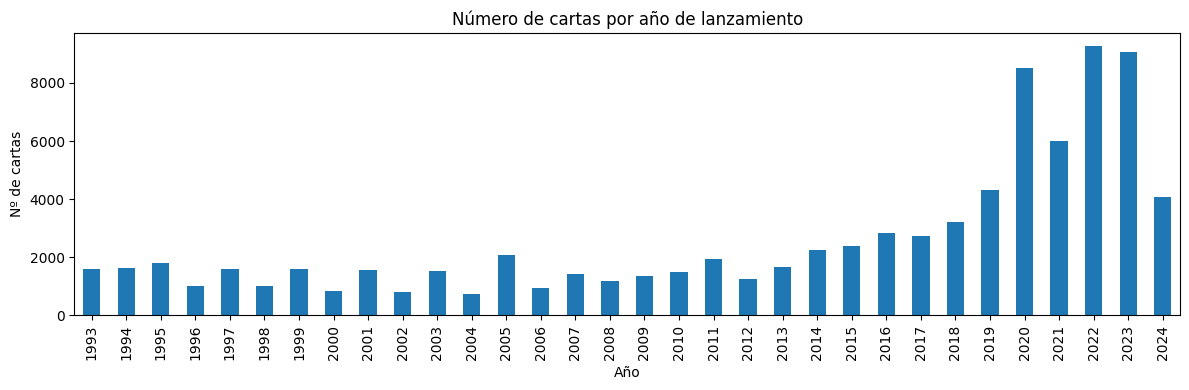

In [506]:
from IPython.display import display

cards_per_year = (
    df_work["release_year"]
    .value_counts()
    .sort_index()
)

# Gráfico: evolución anual completa
plt.figure(figsize=(12,4))
cards_per_year.plot(kind="bar")
plt.title("Número de cartas por año de lanzamiento")
plt.xlabel("Año")
plt.ylabel("Nº de cartas")
plt.tight_layout()
plt.show()

El número de cartas publicadas por año muestra una tendencia estable entre 1993 y 2019, con variaciones moderadas que reflejan las diferencias habituales entre tamaños de sets y ciclos de diseño. A partir de 2020 se observa un incremento abrupto en el volumen total, coincidiendo con el cambio de estrategia de Wizards of the Coast hacia un mayor número de productos anuales: sets suplementarios, colecciones temáticas, expansiones para Commander y líneas especiales como Universes Beyond.

Entre 2020 y 2023 el dataset alcanza máximos históricos por encima de 9.000 cartas por año. Esta cifra no refleja únicamente la línea principal de Magic, sino la agregación de todos los productos recogidos en el dataset (incluyendo reimpresiones, promos y sets suplementarios), lo que explica el crecimiento tan pronunciado.

La aparente caída en 2024 no indica un retroceso real en la producción, sino que es consecuencia de que el dataset solo incluye datos parciales de ese año.

#### 4.1.2. Evolución de la media de palabras por carta

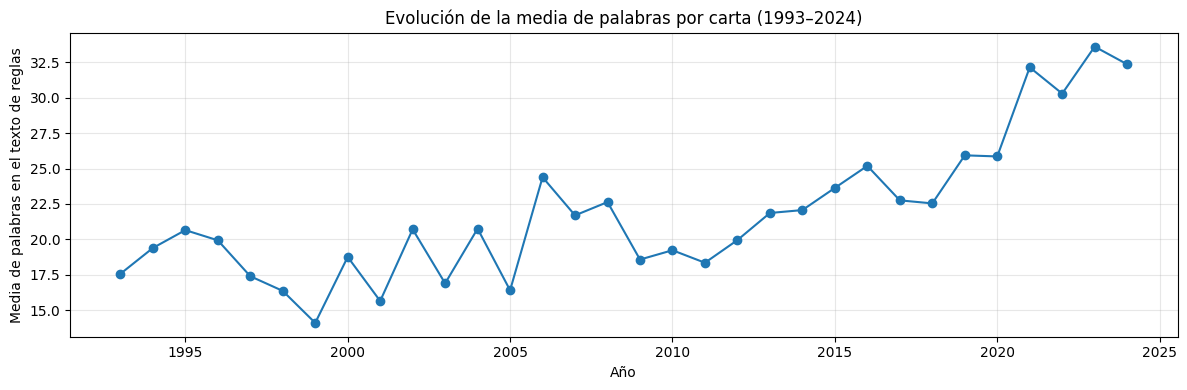

In [507]:
words_per_year = (
    df_work.groupby("release_year")["n_words_text"]
    .mean()
    .rename("mean_words")
)

plt.figure(figsize=(12,4))
words_per_year.plot(kind="line", marker="o")
plt.title("Evolución de la media de palabras por carta (1993–2024)")
plt.xlabel("Año")
plt.ylabel("Media de palabras en el texto de reglas")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

La gráfica muestra un aumento sostenido del número medio de palabras por carta a lo largo del tiempo, lo que refleja un crecimiento progresivo de la complejidad mecánica del juego y un indicio temprano del power creep (aumento gradual del estándar de poder en los diseños nuevos), ya que las cartas modernas tienden a incluir más habilidades, más excepciones y más efectos concatenados.

#### Caída alrededor de 1995

Se observa una reducción clara en la media de palabras alrededor de 1995. En ese periodo, *Magic* seguía consolidándose y *Wizards* empezó a normalizar la escritura de las reglas, reduciendo el texto superfluo de las cartas, lo que se tradujo en una bajada temporal en la complejidad media por carta.

#### Tendencia creciente posterior

A partir de finales de los 90 la complejidad aumenta gradualmente, impulsada por la introducción regular de nuevas mecánicas. La subida es especialmente evidente a partir de 2010–2012 y más aún desde 2018, coincidiendo con:

* la orientación moderna del diseño hacia cartas más técnicas,
* el empuje de formatos como Commander,
* y el incremento general del power creep, que suele venir acompañado de textos más largos.

En conjunto, la tendencia confirma que el *Magic* moderno utiliza **bastante más texto por carta** que el *Magic* clásico, reflejando la evolución natural del juego hacia diseños más complejos y potentes.


#### 4.1.3. Evolución del coste de maná

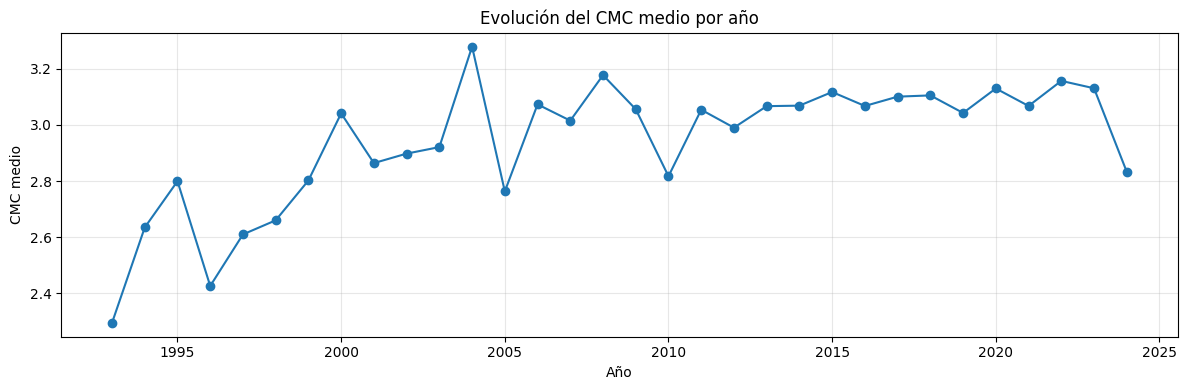

In [508]:
cmc_per_year = (
    df_work.groupby("release_year")["cmc"]
    .mean()
    .dropna()
)

plt.figure(figsize=(12,4))
plt.plot(cmc_per_year.index, cmc_per_year.values, marker="o")
plt.title("Evolución del CMC medio por año")
plt.xlabel("Año")
plt.ylabel("CMC medio")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

La gráfica muestra cómo ha evolucionado el coste de maná convertido medio desde 1993 hasta 2024.

En los primeros años del juego se observa una tendencia ascendente del CMC medio: a medida que aparecen nuevas ediciones, aumentan las criaturas grandes y los hechizos de impacto, y el diseño se va alejando de las cartas muy simples y baratas del inicio.

A partir de mediados de los 2000, el CMC medio se estabiliza alrededor de 3.0–3.1, con pequeñas oscilaciones entre años. Esto sugiere que, una vez consolidado el sistema de juego, Wizards mantiene bastante constante la “altura” media de la curva de maná, alternando sets algo más agresivos con otros algo más pesados sin cambiar el punto de equilibrio global.

El punto más llamativo es la caída en 2024. Este descenso no indica un cambio real en la filosofía de diseño, sino que se debe a que el dataset de ese año está incompleto (faltan productos, especialmente mazos de Commander, que suelen contener muchos hechizos de coste alto), lo que sesga la media a la baja.


#### 4.1.4. Evolución de la rareza

<Figure size 1200x400 with 0 Axes>

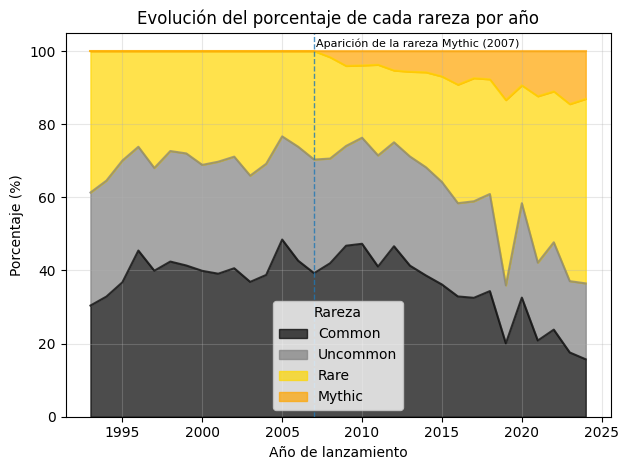

In [535]:
rarity_year = (
    df_work.groupby(["release_year", "rarity"])
           .size()
           .reset_index(name="count")
)

# Tabla ancha para que cada rareza sea una columna, en el orden que queremos
pivot_abs = (
    rarity_year
    .pivot(index="release_year", columns="rarity", values="count")
    .reindex(columns=["Common", "Uncommon", "Rare", "Mythic"]) # Orden creciente de rareza
    .fillna(0)
)

# Porcentajes por año
pivot_pct = pivot_abs.div(pivot_abs.sum(axis=1), axis=0) * 100

# Colores para cada rareza en el mismo orden
rarity_colors = ["black", "grey", "gold", "orange"] 

# Gráfico de áreas apiladas
plt.figure(figsize=(12,4))
pivot_pct.plot(kind="area", stacked=True, color=rarity_colors, alpha=0.7)

plt.title("Evolución del porcentaje de cada rareza por año")
plt.xlabel("Año de lanzamiento")
plt.ylabel("Porcentaje (%)")
plt.grid(True, alpha=0.3)
plt.legend(title="Rareza")

# Línea vertical para marcar la aparición de las Mythic (2007)
plt.axvline(2007, linestyle="--", linewidth=1, alpha=0.8)
plt.text(2007 + 0.1, 101, "Aparición de la rareza Mythic (2007)", fontsize=8)

plt.tight_layout()
plt.show()


La gráfica muestra la evolución de la proporción de cada rareza dentro del total de cartas publicadas anualmente. Se observa una distribución relativamente estable durante las primeras décadas del juego: los porcentajes de Common, Uncommon y Rare se mantienen en rangos consistentes, con oscilaciones moderadas atribuibles a diferencias de diseño entre bloques y al tamaño desigual de los sets.

La línea vertical señala la aparición de la rareza Mythic en 2007, que se integra como un porcentaje reducido pero creciente del total. A partir de ese momento, la proporción de Rare disminuye ligeramente —dado que parte de ese espacio pasa a ocuparlo la nueva rareza— mientras que Mythic va ganando peso de forma progresiva.

Entre 2018 y 2023 se aprecia un cambio estructural más claro: los porcentajes de Rare y Mythic aumentan, mientras que las Common pierden presencia. Este fenómeno está asociado a la mayor producción de productos suplementarios y a la orientación moderna del diseño hacia cartas más llamativas, potentes y textualmente densas, lo que también se relaciona con el power creep.

Finalmente, la caída abrupta en 2024 no refleja un cambio real en las políticas de rareza, sino que se debe a que el dataset solo contiene datos parciales de ese año, produciendo una distorsión en los porcentajes.

### 4.2. Sistema de colores

#### 4.2.1. Distrbución de número de colores por carta

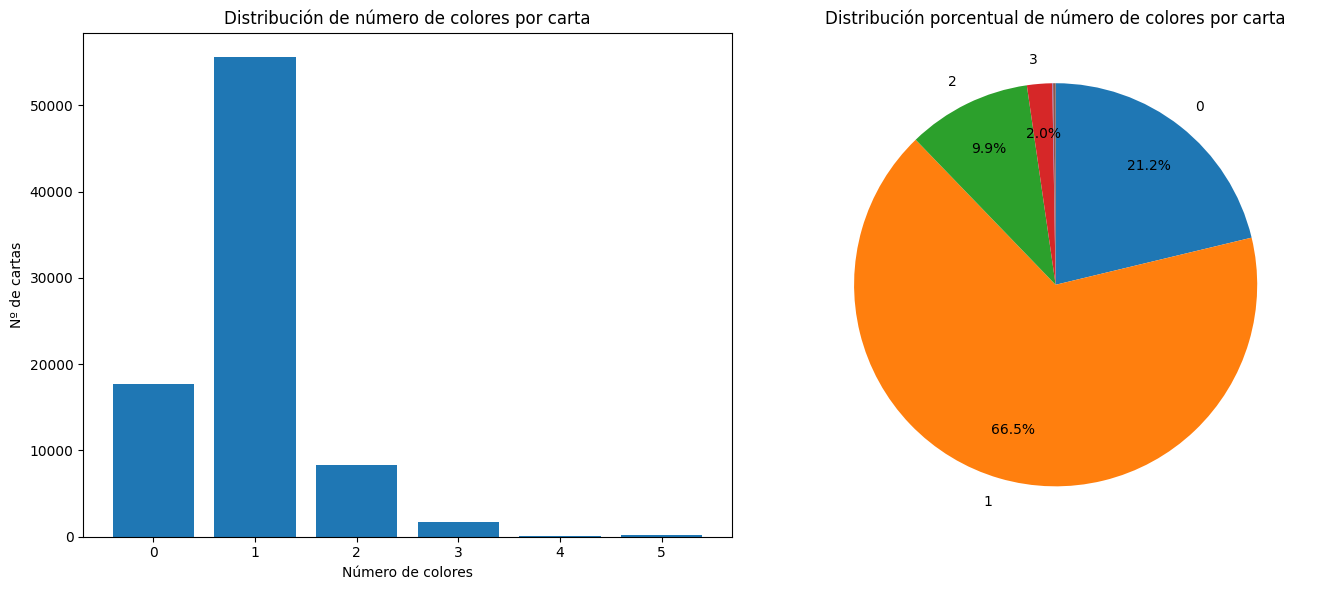

In [512]:
# Para que las cartas incloras sean tratadas como 0 colors en lugar de como monocolors
df_work["num_colors"] = np.where(
    df_work["is_colorless"] == True,
    0,
    df_work["colors"].apply(lambda x: len(x) if isinstance(x, list) else None)
)
df_work["num_colors"].value_counts().sort_index()

color_count_dist = (
    df_work["num_colors"]
    .value_counts()
    .sort_index()
)


fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histograma
axes[0].bar(color_count_dist.index, color_count_dist.values)
axes[0].set_title("Distribución de número de colores por carta")
axes[0].set_xlabel("Número de colores")
axes[0].set_ylabel("Nº de cartas")

# Convertir a porcentaje
color_percentage = (color_count_dist / color_count_dist.sum()) * 100

# Gráfico de tarta
def autopct_filter(p):
    return f"{p:.1f}%" if p > 2 else "" # Mostrar solo si es >2%, para que no se solapen los porcentajes menores

axes[1].pie(
    color_percentage,
    labels=[str(i) if color_percentage[i] > 2 else "" for i in color_percentage.index],
    autopct=autopct_filter,
    startangle=90,
    counterclock=False,
    labeldistance=1.12,   # aleja etiquetas
    pctdistance=0.75      # acerca porcentajes
)

axes[1].set_title("Distribución porcentual de número de colores por carta")

plt.tight_layout()
plt.show()

La distribución muestra una estructura muy clara y coherente con el diseño tradicional de Magic:
- Las cartas incoloras representan un grupo importante. Cabría esperar que su volumen equivaliese a una quinta parte del volumen de las cartas monocolor, ya que el "incoloro" casi se comporta como un sexto color en el juego. Sin embargo, casi todas las tierras, que son el segundo tipo más abundante de carta, son incoloras, lo que hace que la distribución se vea sesgada hacia las cartas sin color.

- Las cartas monocolor son con diferencia el tipo más común del juego, lo que refleja el papel central del color pie y de las identidades de cada color.

- Las cartas multicolor (2–3 colores) existen, pero son minoritarias y suelen concentrarse en sets o bloques temáticos específicos.

- Las cartas de 4 y 5 colores son extremadamente raras y casi siempre corresponden a diseños muy concretos o cartas icónicas con identidad de color total.

En conjunto, esta distribución confirma que el diseño del juego se apoya principalmente en cartas monocolor e incoloras, con la multicoloridad como elemento complementario.

#### 4.2.2. Distribución del *color pie*

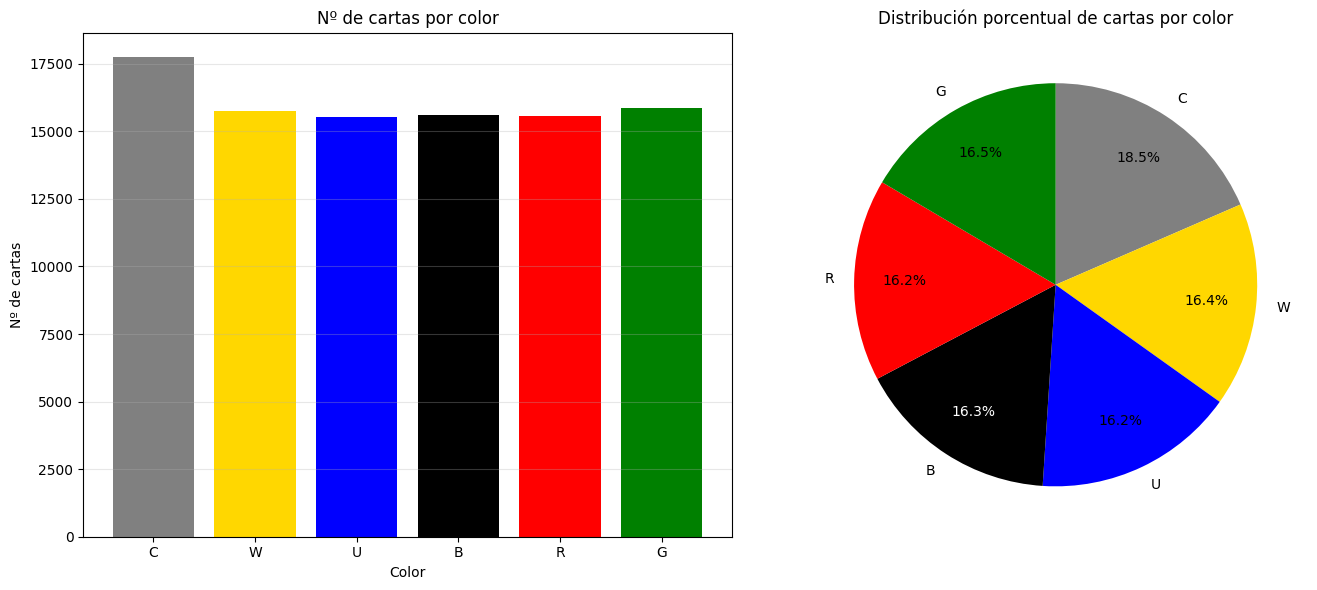

In [513]:
colors_exploded = (
    df_work["colors"]
    .apply(lambda x: x if isinstance(x, list) else [])
    .explode()
)

color_counts = colors_exploded.value_counts()

n_colorless = df_work["colors"].apply(lambda x: len(x)==0).sum()

color_totals = pd.Series({
    "C": color_counts.get("C", 0),
    "W": color_counts.get("W", 0),
    "U": color_counts.get("U", 0),
    "B": color_counts.get("B", 0),
    "R": color_counts.get("R", 0),
    "G": color_counts.get("G", 0)
})

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histograma
axes[0].bar(
    color_totals.index,
    color_totals.values,
    color=["gray", "gold", "blue", "black", "red", "green"]
)
axes[0].set_title("Nº de cartas por color")
axes[0].set_xlabel("Color")
axes[0].set_ylabel("Nº de cartas")
axes[0].grid(axis="y", alpha=0.3)

# Gráfico de tarta
color_pct = color_totals / color_totals.sum() * 100
colors = ["gray","gold","blue","black","red","green"]
labels = color_totals.index

wedges, texts, autotexts = axes[1].pie(
    color_pct,
    labels=labels,
    autopct=lambda p: f"{p:.1f}%",
    startangle=90,
    counterclock=False,
    colors=colors,
    pctdistance=0.75
)

# Ajustar color del porcentaje de las cartas negras (B) 
for label_text in texts:
    label_text.set_color("black")

for i, auto_text in enumerate(autotexts):
    if labels[i] == "B":
        auto_text.set_color("white")
    else:
        auto_text.set_color("black")

axes[1].set_title("Distribución porcentual de cartas por color")

plt.tight_layout()
plt.show()

La figura muestra cuántas cartas aporta cada color al juego, contando **todas las apariciones del color en `colors`** (es decir, una carta multicolor suma en varios colores).

Los resultados son casi perfectamente simétricos: los cinco colores principales (W, U, B, R y G) se mueven en torno al **16–16,5 %** del total, lo que indica que el volumen de diseño está muy equilibrado entre colores. Dentro de ese equilibrio, se ven dos matices:

- **Colorless (C)** es la categoría más grande (≈18,5 %). Esto se explica porque agrupa a la mayoría de **tierras**, que no tienen color en el atributo `colors`.
- Entre los colores clásicos, **G (green)** es el que tiene ligeramente más presencia, lo cual es una absoluta sorpresa, ya que cabría esperar que o bien todos los colores estuviesen perfectamente equilibrados (más después de tantos años de desarrollo del juego), o bien fuese el azul el que tuviese un poquito de exceso, ya que es el "favorito" de Wizards.

En conjunto, estos gráficos confirman que el sistema de color de Magic está globalmente balanceado.

#### 4.2.3. Distribución por color_identity (W, U, B, R, G, combinaciones y "ausencia")

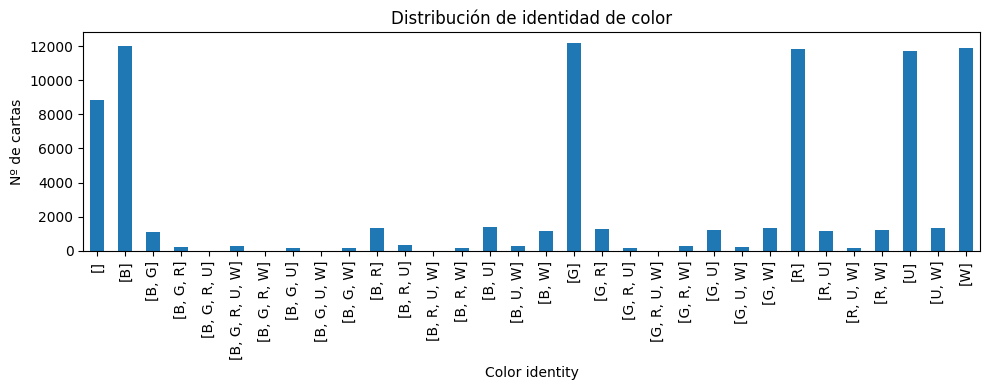

In [514]:
colo_identity = (
    df_work["color_identity"]
    .value_counts()
    .sort_index()
)

plt.figure(figsize=(10,4))
colo_identity.plot(kind="bar")
plt.title("Distribución de identidad de color")
plt.xlabel("Color identity")
plt.ylabel("Nº de cartas")
plt.tight_layout()
plt.show()

La distribución de identidades de color muestra un patrón muy estable: las cartas monocolor y las incoloras dominan globalmente el dataset, mientras que las combinaciones bicolor mantienen entre sí volúmenes similares —sin grandes diferencias entre parejas aliadas o enemigas—, y las identidades tricolor y tetracolor aparecen en cantidades mucho más bajas pero también bastante uniformes dentro de cada grupo. Las identidades pentacolor son excepcionales y corresponden casi siempre a diseños muy concretos.

Un aspecto importante es que, en este gráfico de color_identity, las tierras (que solemos asociar a cartas incoloras) no aparecen en la categoría incolora ([]), ya que casi todas tienen identidad de color (por ejemplo, una tierra con símbolo de maná blanco tiene identidad W, no identidad vacía). Esto contrasta con el gráfico de 3.1, donde las tierras sí inflaban la categoría de cartas sin color (num_colors = 0).

Al combinar ambos gráficos, se obtiene una lectura coherente:
la identidad incolora y cada uno de los cinco colores principales presentan un volumen global comparable, lo cual encaja con la idea de que, a nivel de identidad, el “incoloro” funciona efectivamente como un sexto color dentro del diseño del juego.

### 4.3. Tipos principales de carta

#### 4.3.1. Distribución de los tipos principales

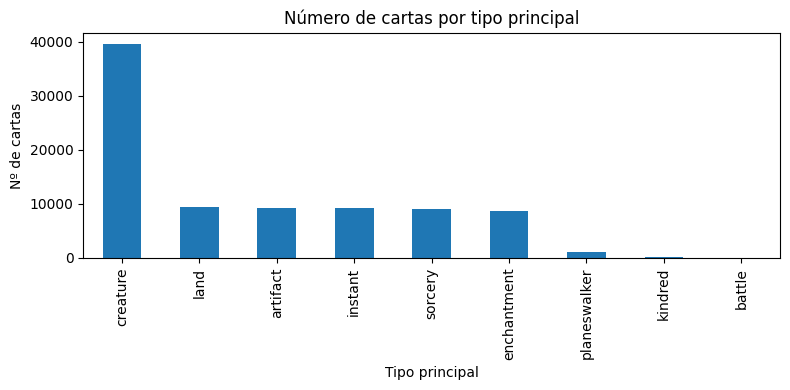

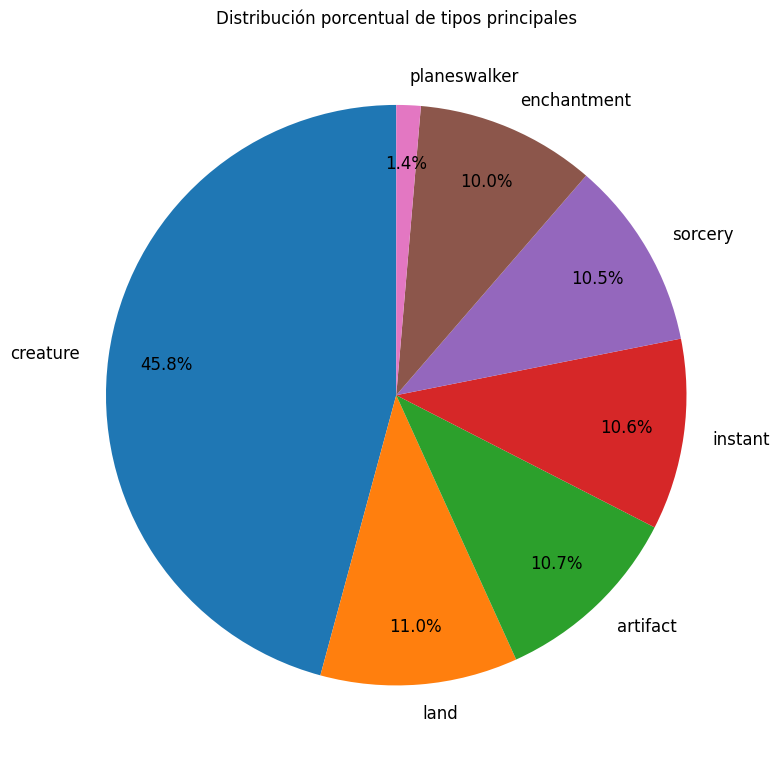

In [515]:
type_flags = [
    "is_creature",
    "is_land",
    "is_artifact",
    "is_enchantment",
    "is_planeswalker",
    "is_instant",
    "is_sorcery",
    "is_kindred",
    "is_battle"
]

type_counts = {
    col.replace("is_", ""): df_work[col].sum()
    for col in type_flags
    if col in df_work.columns
}

type_counts = (
    pd.Series(type_counts)
    .sort_values(ascending=False)
)

# Histograma
plt.figure(figsize=(8,4))
type_counts.plot(kind="bar")
plt.title("Número de cartas por tipo principal")
plt.xlabel("Tipo principal")
plt.ylabel("Nº de cartas")
plt.tight_layout()
plt.show()

# Eliminar tipos con muy pocas cartas para mejorar la visualización
types_to_remove = ["kindred", "battle"]

type_counts_big = type_counts.drop(types_to_remove)

# Gráfico de tarta
plt.figure(figsize=(8,8))
type_counts_big.plot(
    kind="pie",
    autopct="%1.1f%%",
    startangle=90,
    pctdistance=0.8,
    textprops={"fontsize": 12}
)

plt.ylabel("")
plt.title("Distribución porcentual de tipos principales")
plt.tight_layout()
plt.show()

La distribución por tipo principal muestra que las criaturas constituyen el eje central del diseño de Magic, con alrededor del 46% de las cartas del dataset. Instant, sorcery, enchantment, artifact y land aparecen en volúmenes similares (~9–10 mil cartas), lo que sugiere un equilibrio estructural entre amenazas, respuestas y recursos permanentes.

Los planeswalkers, aunque icónicos, no estaban presentes desde el inicio del juego, sino que se introdujeron en 2007, lo que hace que representan un porcentaje muy pequeño del total.
Esto se nota aún más con las battles, las cuales se introdujeron en el juego en un único set, lanzado en 2023.

Contrariamente, si bien los kindred se introdujeron en el juego en 1994 (conocidos entonces como tribals), fue un tipo de carta que se descontinuó (salvo por reimpresiones de cartas antiguas que ya contaban con ese tipo).

#### 4.3.2. Distribución de los tipos de carta según el color

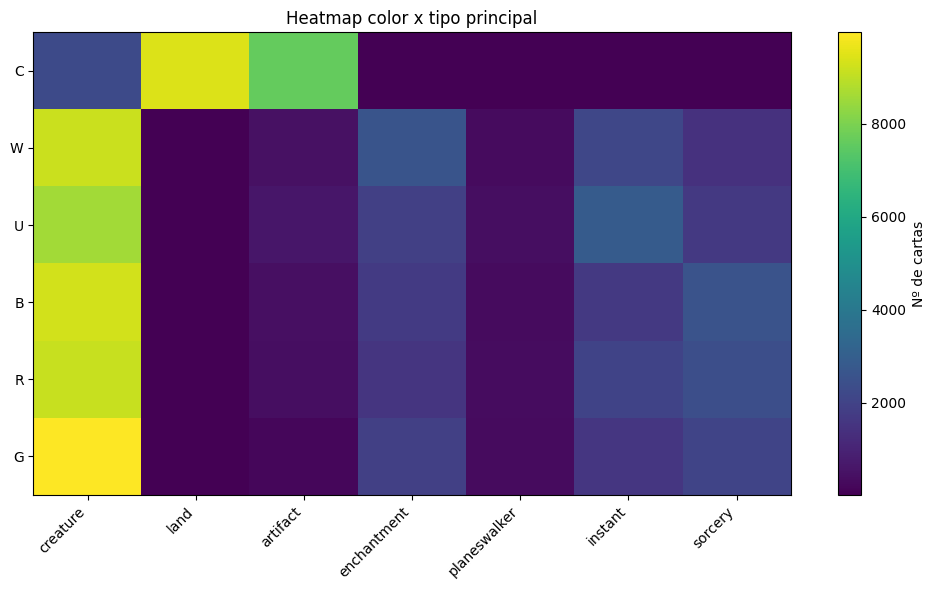

In [516]:
# Orden lógico de colores
color_order = ["C", "W", "U", "B", "R", "G"]

main_type_flags = type_flags = [t for t in type_flags if t not in ["is_battle", "is_kindred"]]

heatmap_type = pd.DataFrame(0, index=color_order, columns=[t.replace("is_","") for t in type_flags], dtype=int)

for color in color_order:
    subset = df_work[df_work["colors"].apply(lambda x: color in x)]
    for tflag in type_flags:
        heatmap_type.loc[color, tflag.replace("is_","")] = subset[tflag].sum()

# Gráfico: heatmap
plt.figure(figsize=(10,6))
plt.imshow(heatmap_type.values, aspect="auto", cmap="viridis")
plt.colorbar(label="Nº de cartas")

plt.xticks(range(len(heatmap_type.columns)), heatmap_type.columns, rotation=45, ha="right")
plt.yticks(range(len(color_order)), color_order)

plt.title("Heatmap color x tipo principal")
plt.tight_layout()
plt.show()

El siguiente heatmap muestra cómo se distribuyen los tipos de carta principales entre los distintos colores del juego. El objetivo es visualizar el *color pie* desde una perspectiva cuantitativa, utilizando los recuentos reales del dataset (ya sin incluir `battle` ni `kindred`).

**Principales conclusiones**

* **El colorless (C)** está dominado por *lands* y *artifacts*, lo cual refleja perfectamente su función en el juego: las tierras básicas y no básicas son incoloras, y la mayoría de artefactos también. Es, con diferencia, el color con menor presencia de hechizos (instants y sorceries).

* **Todos los colores tienen un volumen muy alto de criaturas**, en torno a 10.000–12.000. Esto confirma que *creature* es, históricamente, el tipo más abundante de Magic y el centro mecánico del juego.

* **Blue (U) y Red (R)** destacan especialmente en *instants* y *sorceries*, consolidando su rol clásico como los colores más orientados a hechizos y acciones no permanentes.

* **Green (G)** tiene el número más alto de criaturas y uno de los menores en hechizos, lo cual encaja perfectamente con su filosofía de diseño: permanentes y presencia en mesa.

* **White (W) y Green (G)** presentan los valores más altos en *enchantments*, coherente con sus roles de apoyo, reglas, auras y efectos estáticos.

* **Planeswalkers** aparecen relativamente homogéneos entre colores, reflejando que WoTC los imprime de forma cíclica y que su presencia no está fuertemente sesgada por color.

**Interpretación global**

Este heatmap confirma de manera cuantitativa la estructura histórica del *color pie*. Cada color mantiene sus patrones característicos:

* **C**: tierras y artefactos
* **W**: encantamientos y criaturas
* **U**: hechizos (instants/sorceries)
* **B**: criaturas + hechizos equilibrados
* **R**: hechizos agresivos + criaturas de apoyo
* **G**: criaturas y encantamientos

La distribución es coherente, estable y consistente con 30 años de diseño del juego.

### 4.4. Análisis del texto de reglas

#### 4.4.1. Distribución de keywords

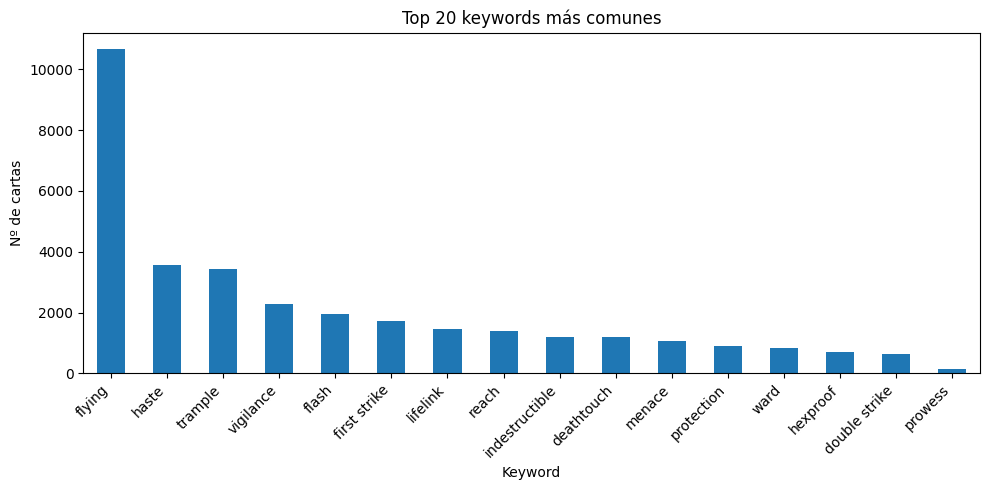

In [517]:
keywords_expanded = (
    df_work["keywords_list"]
    .explode()
    .dropna()
)

keyword_counts = (
    keywords_expanded
    .value_counts()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10,5))
keyword_counts.head(20).plot(kind="bar")
plt.title("Top 20 keywords más comunes")
plt.xlabel("Keyword")
plt.ylabel("Nº de cartas")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Las keywords representan las habilidades codificadas más importantes de Magic: términos como flying, haste, menace o lifelink que describen mecánicas recurrentes y que permiten mantener el texto de reglas manejable.

La distribución revela varios patrones claros:
- Flying es, con diferencia, la keyword más frecuente del juego. Esta habilidad es el principal eje de evasión desde 1993 y aparece en prácticamente todos los sets.

- Haste y trample completan el podio, reflejando que las habilidades asociadas al combate y a la agresividad son omnipresentes en el diseño.

- Keywords defensivas o de control del combate (vigilance, first strike, reach) también tienen alta frecuencia, lo que indica que el juego mantiene un balance constante entre evasión y capacidad defensiva.

- Keywords asociadas a complejidad alta o más recientes (ward, prowess, exploit, etc.) aparecen en posiciones más bajas, mostrando el impacto del power creep moderno pero sin dominar el dataset.

- La distribución tiene una clara estructura de “cola larga”: unas pocas habilidades concentradas en decenas de miles de cartas y una cantidad enorme de keywords que solo aparecen en contextos temáticos o sets concretos.

Esta distribución sirve como una primera aproximación a la “gramática mecánica” del juego: qué habilidades definen la mayor parte del espacio de diseño y cuáles son elementos excepcionales o específicos.

### 4.4.2. Keywords por color (identidad de color)

In [518]:
df_kw_color = (
    df_work[["color_identity", "keywords_list"]]
    .explode("color_identity")
    .explode("keywords_list")
    .dropna(subset=["keywords_list"])  # sólo cartas con al menos una keyword
    .rename(columns={"color_identity": "color", "keywords_list": "keyword"})
)

kw_color_counts = (
    df_kw_color
    .groupby(["color", "keyword"])
    .size()
    .rename("n_cartas")
    .reset_index()
)


=== Top 10 keywords para color W ===


,color,keyword,n_cartas
66,W,flying,3436
76,W,vigilance,1638
70,W,lifelink,970
64,W,first strike,820
69,W,indestructible,538
72,W,protection,523
65,W,flash,498
67,W,haste,452
75,W,trample,413
63,W,double strike,398


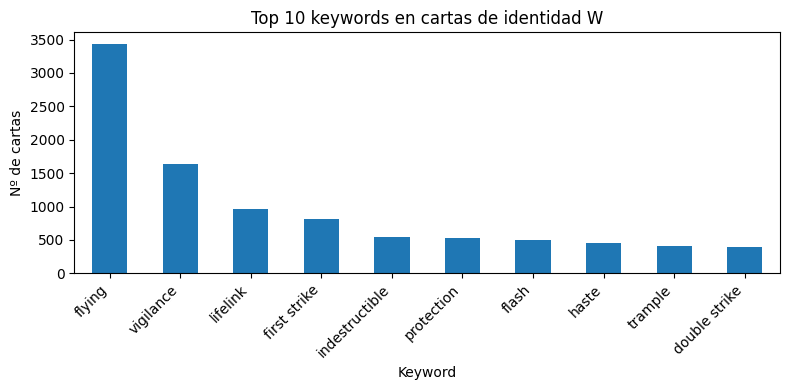


=== Top 10 keywords para color U ===


,color,keyword,n_cartas
50,U,flying,3582
49,U,flash,784
51,U,haste,377
60,U,vigilance,295
61,U,ward,281
59,U,trample,280
52,U,hexproof,226
58,U,reach,175
46,U,deathtouch,149
54,U,lifelink,144


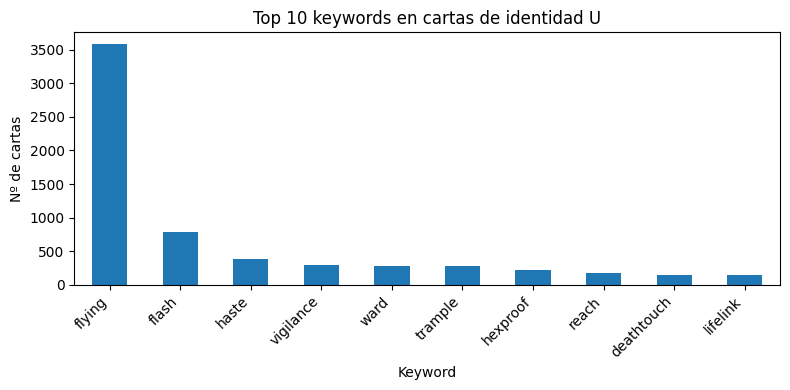


=== Top 10 keywords para color B ===


,color,keyword,n_cartas
4,B,flying,2366
0,B,deathtouch,852
5,B,haste,679
9,B,menace,662
8,B,lifelink,614
12,B,trample,440
3,B,flash,330
2,B,first strike,269
7,B,indestructible,254
11,B,reach,222


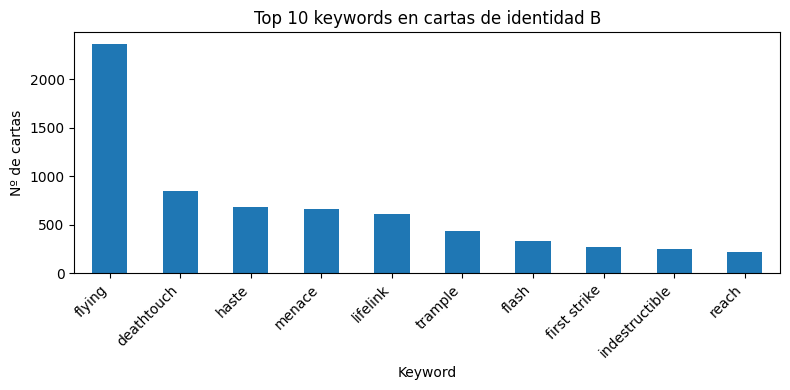


=== Top 10 keywords para color R ===


,color,keyword,n_cartas
35,R,haste,2540
34,R,flying,2020
43,R,trample,1179
32,R,first strike,693
39,R,menace,450
33,R,flash,340
31,R,double strike,296
44,R,vigilance,283
37,R,indestructible,201
42,R,reach,189


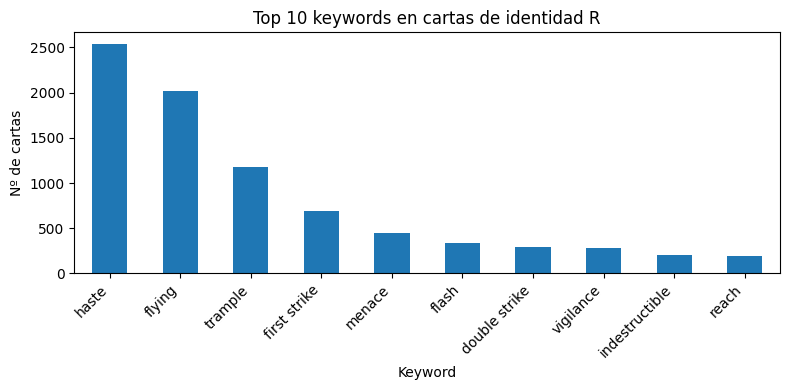


=== Top 10 keywords para color G ===


,color,keyword,n_cartas
27,G,trample,2041
19,G,flying,1345
26,G,reach,760
20,G,haste,643
28,G,vigilance,612
15,G,deathtouch,407
18,G,flash,395
21,G,hexproof,323
22,G,indestructible,299
29,G,ward,218


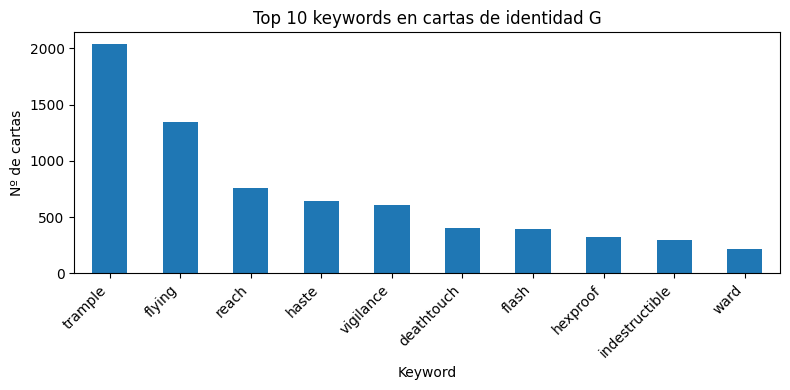

In [519]:
for col in color_order:
    subset = kw_color_counts[kw_color_counts["color"] == col].sort_values("n_cartas", ascending=False)
    if subset.empty:
        continue

    print(f"\n=== Top 10 keywords para color {col} ===")
    display(subset.head(10))

    # Gráfico para este color
    plt.figure(figsize=(8,4))
    subset.head(10).set_index("keyword")["n_cartas"].plot(kind="bar")
    plt.title(f"Top 10 keywords en cartas de identidad {col}")
    plt.xlabel("Keyword")
    plt.ylabel("Nº de cartas")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

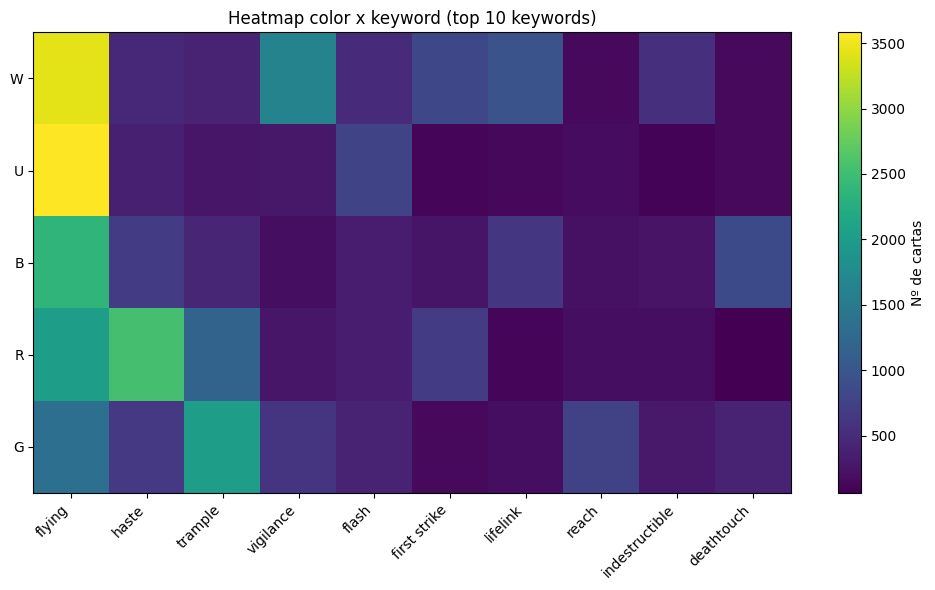

In [520]:
color_order_wo_colorless = ["W", "U", "B", "R", "G"]

top_keywords = list(keyword_counts.head(10).index)

heatmap_kw = pd.DataFrame(0, index=color_order_wo_colorless, columns=top_keywords, dtype=int)

for row in df_kw_color.itertuples():
    c = row.color
    kw = row.keyword

    if (c in color_order_wo_colorless) and (kw in top_keywords):
        heatmap_kw.loc[c, kw] += 1

# Gráfico: heatmap
plt.figure(figsize=(10,6))
plt.imshow(heatmap_kw.values, aspect="auto", cmap="viridis")
plt.colorbar(label="Nº de cartas")

plt.xticks(range(len(top_keywords)), top_keywords, rotation=45, ha="right")
plt.yticks(range(len(color_order_wo_colorless)), color_order_wo_colorless)

plt.title("Heatmap color x keyword (top 10 keywords)")
plt.tight_layout()
plt.show()

**Análisis conjunto de keywords por color (gráficos individuales + heatmap)**

El análisis combinado de los gráficos monocolor y del heatmap color×keyword muestra un patrón muy sólido: cada color de Magic mantiene una **identidad mecánica coherente y consistente**, y las keywords más comunes reflejan directamente los tipos de criatura típicos y la filosofía del diseño del color pie.

**Blanco (W)**

Blanco aparece fuertemente asociado a **flying**, **vigilance**, **lifelink**, **first strike**, **protection** e **indestructible**.
Esto encaja perfectamente con sus criaturas emblemáticas:

* **Ángeles:** flying + lifelink + vigilance
* **Caballeros y soldados:** first strike + protection

Blanco es el color con la mayor concentración de **mecánicas defensivas** y de **consistencia en combate**, algo que se ve claramente tanto en su gráfico individual como en el heatmap.

**Azul (U)**

Azul es el color dominante en **flying**, seguido de **flash** y luego keywords más tácticas como **hexproof** o **ward**.
Esto está impulsado por:

* **Esfinges y dracos** → flying
* **Hechiceros y criaturas reactivas** → flash
* Protección puntual → ward / hexproof

En el heatmap Azul aparece como el color con la mayor concentración de evasión y trucos reactivos.

**Negro (B)**

Negro destaca por **deathtouch**, **menace** y una mezcla de keywords agresivas y letales, con algo de flying.
Esto refleja criaturas típicas como:

* **Vampiros** → flying + lifelink
* **Asesinos / ratas / serpientes** → deathtouch
* **Demonios** → flying + menace

Su firma mecánica (deathtouch + menace) se ve con muchísima claridad en el heatmap, donde la columna de *deathtouch* está prácticamente monopolizada por B y G.

**Rojo (R)**

Rojo es, sin discusión, el líder en **haste**, seguido de **first strike**, **menace**, **trample** y **flying** en menor medida.
Esto viene marcado por:

* **Elementales, bárbaros y goblins** → haste
* **Dragones** → flying
* **Guerreros agresivos** → first strike / menace

En el heatmap, Rojo sobresale especialmente en *haste*, que es casi enteramente suyo, y comparte parte del espacio agresivo con Verde.

**Verde (G)**

Verde domina en **trample**, **reach**, **vigilance** y cierta presencia de **hexproof** e **indestructible**.
Esto corresponde a:

* **Bestias y criaturas enormes** → trample
* **Arqueros y criaturas defensivas** → reach
* **Criaturas sólidas y resistentes** → hexproof / indestructible

El heatmap muestra clarísimo que **reach es prácticamente exclusivo de Verde**, igual que trample es su firma ofensiva.


**Conclusión:**

Uniendo los gráficos monocolor y el heatmap completo se ve un patrón muy claro:

* Cada color tiene **2–3 keywords que lo definen**, estrechamente ligadas a sus tribus y estilo de juego.
* Azul y Blanco comparten la evasión (*flying*).
* Negro y Verde comparten la letalidad (*deathtouch*).
* Rojo y Verde comparten la agresividad (*trample*, *haste*).
* Verde tiene mecánicas casi exclusivas (*reach*).
* Blanco acumula la mayoría de mecánicas defensivas coherentes (*vigilance*, *lifelink*, *protection*, *indestructible*).


### 4.5. Fuerza y resistencia de criaturas

#### 4.5.1. Distribución de fuerza por color

<Figure size 1200x400 with 0 Axes>

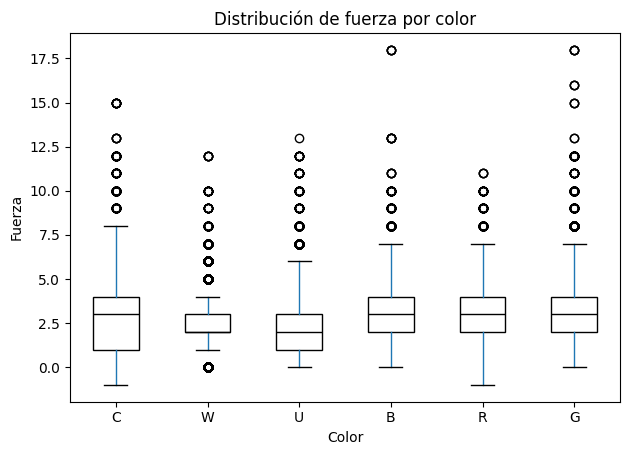

In [577]:
df_power = df_work[df_work["power"].notna()].copy()
df_power = df_power.explode("colors")  # si colors es lista

df_power["colors"] = pd.Categorical(df_power["colors"], categories=color_order, ordered=True) # Para ordenarlos

plt.figure(figsize=(12,4))
df_power.boxplot(column="power", by="colors", grid=False, patch_artist=True, boxprops=dict(facecolor="white"), medianprops=dict(color="black"))

plt.title("Distribución de fuerza por color")
plt.suptitle("") 
plt.xlabel("Color")
plt.ylabel("Fuerza")
plt.tight_layout()
plt.show()

El boxplot muestra cómo varía la fuerza de las criaturas en cada color. Aunque las medianas son similares, las diferencias aparecen en la dispersión y en los valores extremos:

- **Incoloro (C)** → el rango más amplio: desde criaturas muy débiles hasta valores extremadamente altos (≈15). Es el color con mayor variabilidad y más outliers.
- **Blanco (W)** → distribución más contenida, con la mediana ligeramente baja y menos criaturas de fuerza elevada.
- **Azul (U)** → perfil similar a W: fuerza moderada, baja dispersión y pocos outliers altos.
- **Negro (B) y Rojo (R)** → mediana un poco mayor y más dispersión hacia valores de fuerza alta; más criaturas potentes que W/U.
- **Verde (G)** → el más fuerte dentro de los colores, con mediana similar pero numerosos outliers altos (hasta 14–18).

En resumen: C y G destacan por arriba (uno por variabilidad, el otro por fuerza consistente), mientras que W y U son los más contenidos. B y R ocupan un punto intermedio.

#### 4.5.2. Distribución de resistencia por color

<Figure size 1200x400 with 0 Axes>

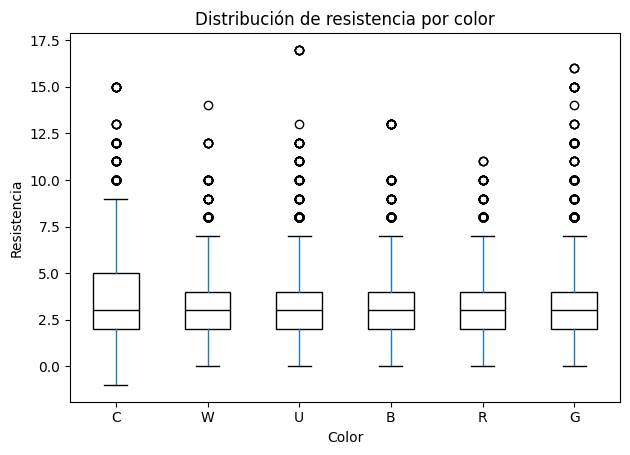

In [578]:
df_tough = df_work[df_work["toughness"].notna()].copy()
df_tough = df_tough.explode("colors")

df_tough["colors"] = pd.Categorical(df_tough["colors"], categories=color_order, ordered=True)

plt.figure(figsize=(12,4))
df_tough.boxplot(column="toughness", by="colors", grid=False, patch_artist=True, boxprops=dict(facecolor="white"), medianprops=dict(color="black"))

plt.title("Distribución de resistencia por color")
plt.suptitle("") 
plt.xlabel("Color")
plt.ylabel("Resistencia")
plt.tight_layout()
plt.show()

El gráfico muestra cómo se reparte la toughness de las criaturas en cada color, y al igual que en el caso de la fuerza, las medianas son parecidas entre colores, pero la dispersión y los outliers permiten distinguir perfiles.

**Incoloro (C)** 
- La distribución es la más amplia de todo el gráfico.
- Presenta criaturas desde resistencia negativa o 0 (no es un error) hasta valores muy altos (15–17).
- Medianamente está alineado con los demás, pero los extremos son muchísimo mayores.
Interpretación: mezcla artefactos pequeños con criaturas enormes (constructos, Eldrazis), generando una resistencia altamente variable.

**Blanco (W), Azul (U), Negro (B) y Rojo (R)** 
- Cajas de tamaño muy similar.
- Medianas alrededor de 2–3 de resistencia.
- Una cantidad comparable de valores atípicos entre 7 y 12.
- Podemos ver que el azul tiene la criatura más resistente del juego (17)

**Verde (G)** 
- Mediana similar al resto (≈2.5–3),
- Pero cola superior más larga, con **más criaturas** alcanzando 12–16 de resistencia.
- Mayor número de outliers altos respecto a los demás colores (no al incoloro).

### 4.6. Coste de maná convestido (CMC)

#### 4.6.1. CMC por color

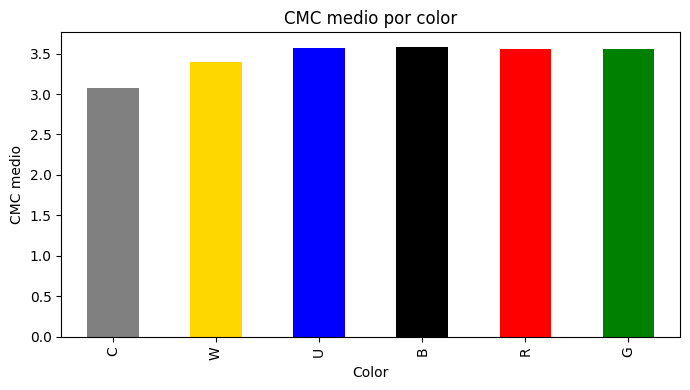

In [521]:
# Hay que quitar las tierras porque la mayoría son incoloras y su CMC es siempre 0, lo que falsearía el análisis
df_nonlands = df_work.loc[~df_work["is_land"]]

df_colors_cmc = (
    df_nonlands
    .explode("colors")[["colors", "cmc"]]
    .dropna(subset=["colors"])
)

cmc_by_color = (
    df_colors_cmc
    .groupby("colors")["cmc"]
    .mean()
)

cmc_by_color = cmc_by_color.reindex(color_order)

plt.figure(figsize=(7,4))
cmc_by_color.plot(
    kind="bar",
    color=["gray", "gold", "blue", "black", "red", "green"]
)
plt.title("CMC medio por color")
plt.xlabel("Color")
plt.ylabel("CMC medio")
plt.tight_layout()
plt.show()

Al excluir las tierras (cuyo coste convertido es siempre 0, lo que distorsionaría la distribución del CMC de las cartas incoloros) el análisis del CMC medio por color muestra que el coste de los hechizos está sorprendentemente nivelado entre los cinco colores principales, lo que sugiere una política de diseño consistente por parte de Wizards para evitar sesgos grandes entre colores. La única excepción ligera es el color incoloro, que por su naturaleza mecánica tiende a incluir más hechizos de coste moderado y bajo.

#### 4.6.2. CMC por rareza

C:\Users\Guille\AppData\Local\Temp\ipykernel_33372\182702729.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_work.groupby("rarity")["cmc"]


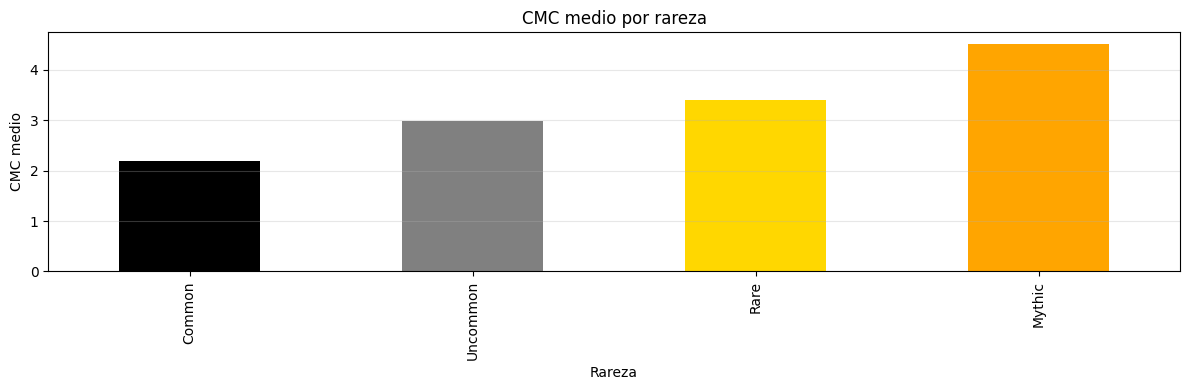

In [552]:
cmc_by_rarity = (
    df_work.groupby("rarity")["cmc"]
           .mean()
           .reindex(["Common", "Uncommon", "Rare", "Mythic"])
)

plt.figure(figsize=(12,4))
cmc_by_rarity.plot(kind="bar", color=rarity_colors)
plt.title("CMC medio por rareza")
plt.xlabel("Rareza")
plt.ylabel("CMC medio")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

El gráfico muestra que el CMC aumenta conforme lo hace la rareza de la carta. 

El menor CMC de las categorías Common y Uncommon refleja su función dentro del diseño del juego: proporcionar efectos sencillos, eficientes y de menor impacto.

Por el contrario, las cartas Rare y especialmente las Mythic aparecen asociadas a CMC medios más elevados. Esto es coherente con su papel de ofrecer efectos más potentes, singulares o de mayor complejidad, que requieren mayores requisitos de maná para equilibrar su impacto en la partida.

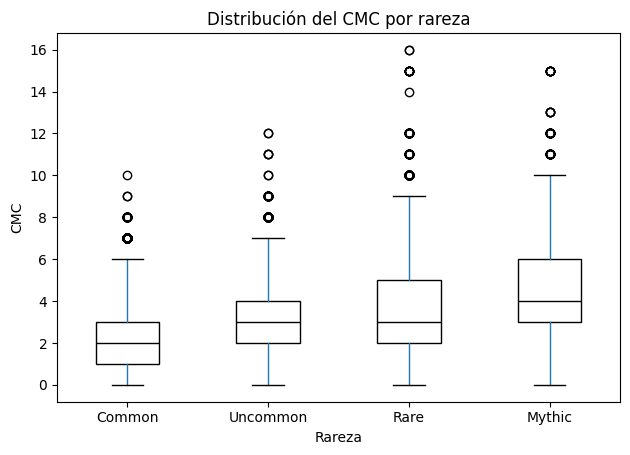

In [542]:
rarity_order = ["Common", "Uncommon", "Rare", "Mythic"]
df_work["rarity"] = pd.Categorical(df_work["rarity"], categories=rarity_order, ordered=True)


df_work.boxplot(
    column="cmc", 
    by="rarity", 
    grid=False,
    patch_artist=True,
    boxprops=dict(facecolor="white"),
    medianprops=dict(color="black")
)
plt.title("Distribución del CMC por rareza")
plt.suptitle("")  # Quita el título extra de pandas
plt.xlabel("Rareza")
plt.ylabel("CMC")
plt.tight_layout()
plt.show()

La distribución del CMC muestra diferencias claras entre rarezas. Las Common presentan un rango estrecho y valores agrupados alrededor de costes muy bajos, lo que refleja su diseño simple y eficiente. Las Uncommon amplían moderadamente ese rango, incorporando efectos algo más elaborados pero aún dentro de una estructura controlada.

Por su parte, las Rare muestran una dispersión notablemente mayor: incluyen tanto cartas baratas como efectos de alto impacto con costes elevados. Finalmente, las Mythic presentan la mayor variabilidad y las colas superiores más largas, indicando la presencia de hechizos especialmente potentes o espectaculares que requieren más maná para equilibrar su fuerza.

En conjunto, el gráfico confirma que la complejidad y el impacto de las cartas aumentan con la rareza, y que las rarezas altas no solo tienden a tener CMC medios más elevados, sino también una mayor diversidad de costes.

### 4.7. Rareza

#### 4.7.1. Rareza por color

C:\Users\Guille\AppData\Local\Temp\ipykernel_33372\1021194325.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_colors.groupby(["colors", "rarity"])


<Figure size 1200x400 with 0 Axes>

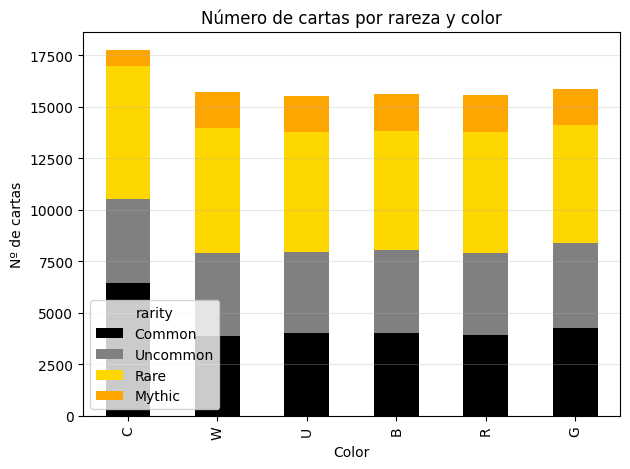

In [553]:
df_colors = df_work.explode("colors").copy()

rarity_color = (
    df_colors.groupby(["colors", "rarity"])
             .size()
             .reset_index(name="count")
)

rarity_color_pivot = (
    rarity_color.pivot(index="colors", columns="rarity", values="count")
                .reindex(["C", "W","U","B","R","G"])
                .fillna(0)
)

plt.figure(figsize=(12,4))
rarity_color_pivot.plot(kind="bar", stacked=True, color=rarity_colors)
plt.title("Número de cartas por rareza y color")
plt.xlabel("Color")
plt.ylabel("Nº de cartas")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


El gráfico muestra la distribución absoluta de cartas de cada rareza dentro de cada color. Los resultados indican que los cinco colores principales (W, U, B, R, G) y el incoloro (C), con las tierras incluidas, presentan patrones prácticamente idénticos, con cantidades muy similares de Common, Uncommon, Rare y Mythic. Esto refleja la intención de Wizards de mantener ratios de rareza equilibrados entre colores a lo largo de la historia del juego.

#### 4.7.2. Rareza por tipo

<Figure size 1200x400 with 0 Axes>

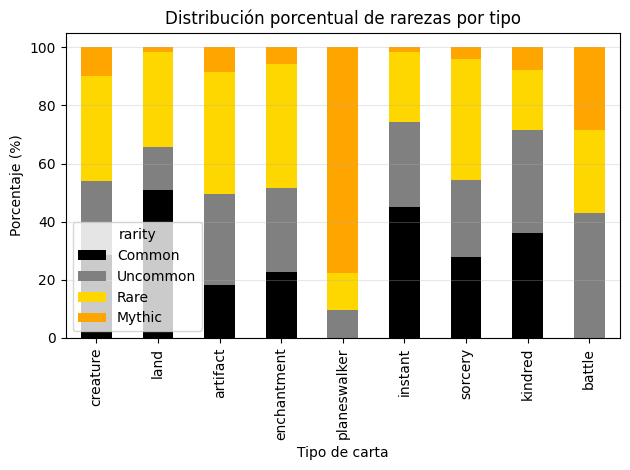

In [ ]:
# Tengo que volver a crear las type_flags porque en algún análisis me he deshecho de "kindred" y "battle"
type_flags = [
    "is_creature",
    "is_land",
    "is_artifact",
    "is_enchantment",
    "is_planeswalker",
    "is_instant",
    "is_sorcery",
    "is_kindred",
    "is_battle"
]

rarity_by_type_dict = {
    col.replace("is_", ""): df_work.loc[df_work[col], "rarity"].value_counts()
    for col in type_flags
    if col in df_work.columns
}

# Conversión a DataFrame: filas = tipos, columnas = rarezas
rarity_by_type = (
    pd.DataFrame(rarity_by_type_dict)
      .T                      # Transponer para tener tipos en filas
      .reindex(columns=rarity_order)
      .fillna(0)
      .astype(int)
)

rarity_by_type_pct = rarity_by_type.div(rarity_by_type.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12,4))
rarity_by_type_pct.plot(kind="bar", stacked=True, color=rarity_colors)

plt.title("Distribución porcentual de rarezas por tipo")
plt.xlabel("Tipo de carta")
plt.ylabel("Porcentaje (%)")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

El gráfico muestra cómo se reparte la rareza dentro de cada tipo de carta. En los tipos más numerosos del juego (e incluso en Kindred) se aprecia un patrón estable y esperado: predominio de Common y Uncommon, con proporciones moderadas de Rare y una fracción menor de Mythic. Esto refleja la estructura básica del diseño de Magic, donde estos tipos constituyen el núcleo del juego y mantienen ratios de rareza muy consistentes.

Algunos tipos muestran comportamientos distintivos:

- Planeswalker presenta una proporción extraordinariamente alta de Rare y Mythic y una ausencia total de Common. Esto es coherente ya que, inicialmente, los Planeswalkers sólo existían en rareza Mythic. Sin embargo, en 2019 comenzaron a imprimir este tipo de carta con sus mecánicas características, aunque con un nivel de poder menor, con lo que fue posible disminuir su rareza.

- Land tiene una presencia relativamente baja de Mythic, pero cuenta con una proporción elevada de Common, principalmente debido a que las tierras básicas, que son parte fundamental del núcleo del juego, suponen un ~40% del total de las lands (~4.5% del total de cartas dataframe).

- Battle presenta una distribución irregular debido a su bajo volumen total: al ser un tipo muy escaso en términos absolutos, cualquier impresión rara o mítica domina fácilmente el porcentaje; aunque me sorprende comprobar que no existen Battles en rareza Common.

En conjunto, los datos muestran que la rareza no se distribuye de forma uniforme entre los tipos, sino que está fuertemente condicionada por la función de cada tipo dentro del diseño del juego.

## 5. Conclusiones

El análisis del dataset permite extraer varias conclusiones coherentes entre sí sobre la evolución del juego, su sistema de colores y la estructura de diseño (tipos, rarezas, costes y criaturas).

### 5.1. Evolución temporal: más volumen, más complejidad y más rarezas altas

- El número de cartas por año se mantiene relativamente estable desde 1993 hasta 2019, con variaciones razonables según el tamaño de los sets. A partir de 2020, el volumen anual de cartas se dispara por encima de las 9.000, impulsado por la proliferación de productos: sets suplementarios, colecciones temáticas, expansiones de Commander y líneas como *Universes Beyond*.

- La media de palabras por carta crece de forma clara con el tiempo, con una caída alrededor de 1995 (normalización del texto de reglas) y una tendencia fuertemente ascendente desde finales de los 90. En la etapa reciente (aprox. desde 2010–2012 y especialmente desde 2018) el texto por carta aumenta de forma marcada, reflejando un juego más complejo, con más habilidades, excepciones y efectos encadenados, y ligado al fenómeno del *power creep* que se ha descrito en el propio análisis.

- El coste de maná convertido (CMC) medio sube en los primeros años del juego y luego se estabiliza alrededor de 3.0–3.1, alternando ligeras oscilaciones entre ediciones. Esto sugiere que, pese al aumento de complejidad y volumen de productos, la “altura” media de la curva de maná se mantiene bastante constante a lo largo del tiempo.

- En la evolución de la rareza por año se observa primero una estructura bastante estable entre Common, Uncommon y Rare, y después, a partir de 2007, la aparición de Mythic como una fracción pequeña pero creciente del total. Desde alrededor de 2018–2023, Rare y Mythic ganan peso mientras Common pierde proporción, lo que encaja con la etapa de mayor complejidad y volumen de productos, y refuerza la idea de un diseño más cargado de cartas de mayor impacto .

En conjunto, la evolución temporal muestra una correlación clara entre **volumen de producto**, **complejidad del texto** y **peso relativo de rarezas altas**, mientras el CMC medio se mantiene sorprendentemente estable, lo que permite afirmar la existencia del *power creep*.

### 5.2. Sistema de tipos y colores: un esqueleto muy estable

- Por tipo principal, las criaturas son claramente el eje del juego (≈46% del dataset), mientras que instant, sorcery, enchantment, artifact y land aparecen en volúmenes similares. Esto dibuja un esqueleto muy equilibrado entre amenazas, respuestas y recursos permanentes. 

- La distribución de tipos según el color muestra que cada color tiene acceso a un “pack” bastante completo de herramientas (criaturas, hechizos, permanentes), pero con matices: algunos colores se inclinan más hacia hechizos instantáneos y conjuros y otros hacia permanentes de mesa, reflejando la filosofía del *color pie* descrita en el análisis.

- En la variable “número de colores”, las cartas incoloras y monocolor dominan con mucha diferencia. Las cartas de 2–3 colores son minoritarias y la presencia de 4–5 colores es casi anecdótica. 

A nivel estructural, los datos confirman un diseño muy controlado: el sistema de tipos y colores se mantiene consistente y sirve de base a la complejidad creciente sin cambiar de “esqueleto”.

### 5.3. Rareza, tipos y costes: cómo se reparte el “poder” del juego

- Cuando se mira la rareza por color, todos los colores (incluido el incoloro) presentan patrones muy similares de Common, Uncommon, Rare y Mythic. Esto sugiere una política explícita de mantener **ratios de rareza equilibrados entre colores**, evitando que un color concentre de forma sistemática las rarezas altas .

- En cambio, la rareza por tipo sí muestra diferencias fuertes: los tipos “núcleo” (criatura, instant, sorcery, enchantment, artifact, land) siguen el patrón clásico de abundancia de Common/Uncommon y proporciones moderadas de Rare/Mythic, mientras que Planeswalker está casi exclusivamente en rarezas altas, Land concentra muchas Common por el peso de las tierras básicas, y Battle presenta una distribución más errática por su bajo volumen total. Es decir, **la rareza correlaciona sobre todo con la función del tipo**, más que con el color en sí.

- El CMC por rareza confirma esa misma lógica: las Common se agrupan alrededor de costes bajos y con rango estrecho; las Uncommon amplían ligeramente el rango; las Rare presentan mucha más dispersión (desde costes bajos hasta hechizos muy caros) y las Mythic muestran las colas superiores más largas y la mayor variabilidad. En conjunto, **a mayor rareza, más diversidad y mayores costes potenciales**, coherente con su papel de cartas de “alto impacto”.

- Por el contrario, el CMC medio por color es muy similar entre W, U, B, R y G, con el incoloro ligeramente más bajo. Esto refuerza la idea de que las diferencias entre colores no vienen tanto de tener “cartas más caras” o “más baratas” en media, sino de **qué hacen** esas cartas (palabras clave, tipo de efectos, distribución de fuerza y resistencia).

### 5.4. Criaturas y perfiles de color: dónde están las estadísticas extremas

- El análisis de la fuerza por color muestra medianas relativamente cercanas entre colores, pero distribuciones distintas en los extremos: el incoloro concentra varias criaturas de fuerza muy alta (constructos, Eldrazis y artefactos grandes) al tiempo que incluye cuerpos muy pequeños, generando la mayor dispersión del gráfico. El verde tiende a aportar más criaturas con fuerza elevada que el resto de colores principales, aunque comparte con ellos una mediana similar.

- En la resistencia ocurre algo análogo: el incoloro presenta el rango más amplio (incluyendo valores extremos muy altos y también resistencias muy bajas), mientras que blanco, azul, negro y rojo tienen cajas muy parecidas en torno a 2–3 de resistencia, con outliers moderados. El verde destaca por una cola superior más larga y más criaturas alcanzando resistencias muy altas (12–16), indicando una **correlación clara entre color verde y criaturas especialmente robustas**, en línea con la identidad clásica del color.

En resumen, **las diferencias estadísticas entre colores aparecen sobre todo en las colas de las distribuciones de fuerza y resistencia**, más que en las medianas.

### 5.5. Palabras clave y color pie: la identidad mecánica de cada color

- El análisis de keywords por color refuerza de forma muy nítida el *color pie* clásico del juego: palabras clave como *Flying*, *Deathtouch*, *Lifelink*, *Haste*, *Trample*, etc., se concentran en los colores esperables, y los patrones de co-ocurrencia por color encajan con la filosofía que los jugadores conocen (por ejemplo, evasión y control en azul, removal y sacrificios en negro, agresividad directa en rojo, criaturas grandes y mejoras de combate en verde, y más apoyo/orden en blanco).

- Esa distribución de keywords, combinada con lo visto en fuerza/resistencia y tipos predominantes, muestra que la identidad de cada color no se basa en “tener más cartas” o “tener costes más altos”, sino en **cómo se combinan estadísticas, tipos de hechizo y palabras clave** para dar lugar a estilos de juego diferenciados pero internamente consistentes.

### 5.6. Visión global

Tomando todas las piezas juntas, el análisis sugiere que:

- El juego ha experimentado una **expansión masiva en volumen de producto y complejidad de cartas** en las últimas dos décadas, con especial aceleración desde 2018.
- Pese a ello, el diseño mantiene un esqueleto muy estable: distribución de tipos, equilibrio del color pie, CMC medio relativamente constante y ratios de rareza equilibrados entre colores.
- Las diferencias más importantes aparecen en las **relaciones entre variables**:
  - rareza ↔ CMC y dispersión de costes,
  - rareza ↔ tipo de carta,
  - color ↔ perfil de fuerza/resistencia,
  - color ↔ conjunto de keywords,
  - etapa temporal reciente ↔ mayor peso de rarezas altas y textos más largos.

En conjunto, el dataset describe un *Magic* que ha crecido en complejidad y producción, pero que conserva de forma sorprendentemente firme su estructura de diseño básica y la identidad mecánica de cada color.
